In [ ]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import classification_report
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataPath = "/content/drive/MyDrive/MDataFiles_Stage2"
csvFiles = dict()
for filename in os.listdir(dataPath):
  name = filename[0:len(filename)-4]
  filePathTmp = dataPath + "/" + filename
  if (name == "MTeamSpellings"):
    csvFiles[name] = pd.read_csv(filePathTmp, encoding = "mac_roman").copy()
  else:
    csvFiles[name] = pd.read_csv(filePathTmp).copy()

  
# To potentially add:
# 1: MConferenceTourneyGames; MSecondaryTourneyTeams, MSecondaryTourneyCompactResults, & SecondaryTourney
# --> get results for conference games
# 2: Incorporating MMasseyOrdinals RankingDayNum by day
# 3: MGameCities --> get city location of games
# 4: MNCAATourneySeedRoundSlots --> bracket sim
# 5: MTeams --> incorporate number of years in tourney since 2003

In [ ]:
df_conferences = csvFiles["MTeamConferences"].copy()
df_seasons = csvFiles["MTeams"].copy()
df_seasons["HasTerminated"] = np.where(df_seasons["LastD1Season"] != 2022, 1, 0)
df_seasons=df_seasons.drop(["TeamName", "LastD1Season"],axis=1)

df_seasons_conferences = pd.merge(
    df_conferences.copy(),
    df_seasons.copy(),
    how = "left",
    on = "TeamID"
)
df_seasons_conferences["NumSeasons"] = df_seasons_conferences["Season"] - df_seasons_conferences["FirstD1Season"]
df_seasons_conferences=df_seasons_conferences.drop("FirstD1Season", axis=1)
df_coaches = csvFiles["MTeamCoaches"][csvFiles["MTeamCoaches"]["Season"] >= 2003]

df_coaches["FullSeason"] = df_coaches["LastDayNum"] - df_coaches["FirstDayNum"]
df_coaches["SeasonDays"] = df_coaches["LastDayNum"] - df_coaches["FirstDayNum"]
df_coaches["FullSeason"] = np.where(df_coaches["FullSeason"] == 154, True, False)

df_season_results = csvFiles['MRegularSeasonDetailedResults']
df_season_results["ScoreMargin"] = csvFiles['MRegularSeasonDetailedResults']['WScore'] - csvFiles['MRegularSeasonDetailedResults']['LScore']

df_season_results.drop(['WLoc', "NumOT"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
sabermetrics = pd.DataFrame()
# TODO (2023): Modify sabermetrics to NOT remove all the other features (WFGA, WAst, etc.)
# TODO (2023): Use data from: https://www.teamrankings.com/ncb/rankings/
# TODO (2023): Add these features (note some more are scattered throughout the code)
# Percentage of Points from 3s, 2s, and 1s
# "quad 1 wins / quad 4 losses" (??? ask next year and reference: https://www.kaggle.com/c/ncaam-march-mania-2021/discussion/231665)
# Strength of Schedule; Schedule Rank

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']
sabermetrics['DayNum'] = df_season_results['DayNum']

# Number of Possessions (Estimated hyperparameter: .44)
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# TODO (2023): Adjusted PtsPerPoss/PtsAllowedPerPoss?
# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Points Allowed Per Possession:
sabermetrics['WPtsAllowedPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']
sabermetrics['LPtsAllowedPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']


# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Offensive Rebound Percentage
sabermetrics['WOReboundPct'] = df_season_results['WOR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])
sabermetrics['LOReboundPct'] = df_season_results['LOR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])

# Defensive Rebound Percentage
sabermetrics['WDReboundPct'] = df_season_results['WDR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LDReboundPct'] = df_season_results['LDR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Assist to Turnover Ratio
sabermetrics['WATORatio'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LATORatio'] = df_season_results['LAst'] / df_season_results['LTO']

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']

sabermetrics["WFGM3"] = df_season_results['WFGM3']
sabermetrics["LFGM3"] = df_season_results['LFGM3']
sabermetrics["WOR"] = df_season_results['WOR']
sabermetrics["LOR"] = df_season_results['LOR']
sabermetrics["WBlk"] = df_season_results['WBlk']
sabermetrics["LBlk"] = df_season_results['LBlk']
sabermetrics["WStl"] = df_season_results['WStl']
sabermetrics["LStl"] = df_season_results['LStl']
sabermetrics["WPF"] = df_season_results['WPF']
sabermetrics["LPF"] = df_season_results['WPF']

winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]
winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']
sabermetrics

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Season,WTeamID,LTeamID,DayNum,WPossessions,LPossessions,WPtsPerPoss,LPtsPerPoss,WPtsAllowedPerPoss,LPtsAllowedPerPoss,...,WFGM3,LFGM3,WOR,LOR,WBlk,LBlk,WStl,LStl,WPF,LPF
0,2003,1104,1328,10,74.92,70.68,0.907635,0.877193,0.877193,0.907635,...,3,2,14,10,1,2,7,9,22,22
1,2003,1272,1393,10,68.36,67.80,1.023991,0.929204,0.929204,1.023991,...,8,6,15,20,4,6,4,8,18,18
2,2003,1266,1437,11,63.76,64.12,1.144918,0.951341,0.951341,1.144918,...,8,3,17,31,2,5,5,2,25,25
3,2003,1296,1457,11,57.64,57.60,0.971548,0.868056,0.868056,0.971548,...,3,6,6,17,2,3,14,4,18,18
4,2003,1400,1208,11,63.72,62.88,1.208412,1.129135,1.129135,1.208412,...,6,6,17,21,4,1,4,7,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102027,2022,1222,1272,132,62.36,63.16,1.138550,0.839139,0.839139,1.138550,...,8,1,13,9,3,4,10,5,16,16
102028,2022,1234,1345,132,67.12,66.48,1.117402,0.992780,0.992780,1.117402,...,8,5,10,17,3,2,13,4,17,17
102029,2022,1350,1172,132,65.92,63.48,0.970874,0.976686,0.976686,0.970874,...,5,9,4,4,0,2,5,4,17,17
102030,2022,1397,1401,132,63.16,60.92,1.029132,0.820749,0.820749,1.029132,...,12,4,12,10,4,0,8,6,14,14


In [ ]:
tmp = pd.merge(
    df_season_results,
    df_seasons_conferences, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID'],axis=1).rename(columns={'ConfAbbrev': 'ConfAbbrevW', 'NumSeasons': 'NumSeasonsW','HasTerminated': 'HasTerminatedW'})
df_season_results = pd.merge(
    tmp,
    df_seasons_conferences, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'ConfAbbrev': 'ConfAbbrevL', 'NumSeasons': 'NumSeasonsL','HasTerminated': 'HasTerminatedL'})

tmp = pd.merge(
    df_season_results,
    df_coaches, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'CoachName': 'CoachW', "FullSeason": "FullSeasonW", "SeasonDays": "SeasonDaysW"})
tmp = tmp[(tmp.DayNum >= tmp.FirstDayNum) & (tmp.DayNum <= tmp.LastDayNum)]
tmp.drop(["FirstDayNum", "LastDayNum"], axis=1, inplace=True)
df_season_results = pd.merge(
    tmp,
    df_coaches, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'CoachName': 'CoachL',"FullSeason": "FullSeasonL", "SeasonDays": "SeasonDaysL"})
df_season_results = df_season_results[(df_season_results.DayNum >= df_season_results.FirstDayNum) & (df_season_results.DayNum <= df_season_results.LastDayNum)]
df_season_results.drop(["FirstDayNum", "LastDayNum"], axis=1, inplace=True)

In [ ]:
seasonPeriodicalRecords = pd.DataFrame()
minYear = min(df_season_results["Season"])
maxYear = max(df_season_results["Season"])


for season in range (minYear, maxYear+1):
  seasons_df = df_season_results[df_season_results["Season"] <= season]
  select_df = df_season_results[df_season_results["Season"] == season]

  num_win_coaches = seasons_df.groupby(["Season",'CoachW']).count() 
  num_win_coaches = num_win_coaches.reset_index()[["Season",'CoachW', 'DayNum']].rename(columns={"DayNum": "CoachWins", "CoachW": "Coach"}).fillna(0)
  num_win_coaches = num_win_coaches.drop("Season", axis=1)
  num_win_coaches = num_win_coaches.groupby(["Coach"]).sum()
  num_win_coaches["Season"] = season

  num_loss_coaches = seasons_df.groupby(["Season",'CoachL']).count() 
  num_loss_coaches = num_loss_coaches.reset_index()[["Season",'CoachL', 'DayNum']].rename(columns={"DayNum": "CoachLosses", "CoachL": "Coach"}).fillna(0)
  num_loss_coaches = num_loss_coaches.drop("Season", axis=1)
  num_loss_coaches = num_loss_coaches.groupby(["Coach"]).sum()
  num_loss_coaches["Season"] = season


  if (season == minYear):
    seasonPeriodicalRecords = pd.merge(
        num_win_coaches,
        num_loss_coaches,
        how = "inner",
        on = ["Season", "Coach"]
    ).reset_index()[["Coach","CoachWins", "Season", "CoachLosses"]]
  else:
    dfTmp = pd.merge(
        num_win_coaches,
        num_loss_coaches,
        how = "inner",
        on = ["Season", "Coach"]
    ).reset_index()[["Coach","CoachWins", "Season", "CoachLosses"]]
    dfModel = dfTmp.loc[dfTmp['Coach'].isin(select_df['CoachW']) | dfTmp['Coach'].isin(select_df['CoachL'])]

    seasonPeriodicalRecords = pd.concat([seasonPeriodicalRecords, dfModel], axis=0)



  
 
  

In [ ]:
sabermetrics_season_w = winning_columns.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
sabermetrics_season_l = losing_columns.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})


In [ ]:
# TODO (2023): Team Win/Loss Against Other Conf's

num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)
win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)
lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

# TODO (2023): Conf Win/Loss Against Other Conf's
num_win_conf = df_season_results.groupby(['Season','ConfAbbrevW']).count()
num_win_conf = num_win_conf.reset_index()[['Season', 'ConfAbbrevW', 'DayNum']].rename(columns={"DayNum": "ConfWins", "ConfAbbrevW": "ConfAbbrev"}).fillna(0)
num_loss_conf = df_season_results.groupby(["Season",'ConfAbbrevL']).count()
num_loss_conf = num_loss_conf.reset_index()[["Season",'ConfAbbrevL', 'DayNum']].rename(columns={"DayNum": "ConfLosses", "ConfAbbrevL": "ConfAbbrev"}).fillna(0)
win_conf_score_margin = df_season_results.groupby(['Season', 'ConfAbbrevW']).mean().reset_index()
win_conf_score_margin = win_conf_score_margin[['Season', 'ConfAbbrevW', 'ScoreMargin']].rename(columns={"ScoreMargin": "ConfAvgWinningScoreMargin", "ConfAbbrevW": "ConfAbbrev"}).fillna(0)
loss_conf_score_margin = df_season_results.groupby(['Season', 'ConfAbbrevL']).mean().reset_index()
loss_conf_score_margin = loss_conf_score_margin[['Season', 'ConfAbbrevL', 'ScoreMargin']].rename(columns={"ScoreMargin": "ConfAvgLosingScoreMargin", "ConfAbbrevL": "ConfAbbrev"}).fillna(0)

df_features_season_w = df_season_results.groupby(['Season', 'ConfAbbrevW','WTeamID']).count().reset_index()[['Season', "ConfAbbrevW",'WTeamID']].rename(columns={"WTeamID": "TeamID","ConfAbbrevW":"ConfAbbrev"})
df_features_season_l = df_season_results.groupby(['Season', "ConfAbbrevL",'LTeamID']).count().reset_index()[['Season', "ConfAbbrevL",'LTeamID']].rename(columns={"LTeamID": "TeamID","ConfAbbrevL":"ConfAbbrev"})

In [ ]:
mean_win_score = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()[['Season', 'WTeamID', 'WScore']]
mean_win_score = mean_win_score.rename(columns={"WTeamID": "TeamID","WScore": "MeanScorewin"})
mean_lose_score = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()[['Season', 'LTeamID', 'LScore']]
mean_lose_score = mean_lose_score.rename(columns={"LTeamID": "TeamID", "LScore": "MeanScorelost"})


In [ ]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_win_conf, on=['Season', 'ConfAbbrev'], how='left')
df_features_season = df_features_season.merge(num_loss_conf, on=['Season', 'ConfAbbrev'], how='left')
df_features_season = df_features_season.merge(win_conf_score_margin, on=['Season', 'ConfAbbrev'], how='left')
df_features_season = df_features_season.merge(loss_conf_score_margin, on=['Season', 'ConfAbbrev'], how='left')
df_features_season = df_features_season.merge(mean_win_score, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(mean_lose_score, on=['Season', 'TeamID'], how='left')

df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)
df_features_season['AvgWinningScoreMargin'] = df_features_season['AvgWinningScoreMargin'].fillna(0)
df_features_season['AvgLosingScoreMargin'] = df_features_season['AvgLosingScoreMargin'].fillna(0)
df_features_season['WinPercentage'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)
df_features_season.drop(['AvgWinningScoreMargin', 'AvgLosingScoreMargin'], axis=1, inplace=True)

df_features_season['ConfWins'] = df_features_season['ConfWins'].fillna(0)
df_features_season['ConfLosses'] = df_features_season['ConfLosses'].fillna(0)
df_features_season['ConfAvgWinningScoreMargin'] = df_features_season['ConfAvgWinningScoreMargin'].fillna(0)
df_features_season['ConfAvgLosingScoreMargin'] = df_features_season['ConfAvgLosingScoreMargin'].fillna(0)
df_features_season['ConfWinPercentage'] = df_features_season['ConfWins'] / (df_features_season['ConfWins'] + df_features_season['ConfLosses'])
df_features_season['ConfAvgScoringMargin'] = (
    (df_features_season['ConfWins'] * df_features_season['ConfAvgWinningScoreMargin'] - 
    df_features_season['ConfLosses'] * df_features_season['ConfAvgLosingScoreMargin'])
    / (df_features_season['ConfWins'] + df_features_season['ConfLosses'])
)
df_features_season.drop(['ConfAvgWinningScoreMargin', 'ConfAvgLosingScoreMargin', "ConfAbbrev"], axis=1, inplace=True)

df_features_season["MeanScorewin"] = df_features_season["MeanScorewin"].fillna(0)
df_features_season["MeanScorelost"] = df_features_season["MeanScorelost"].fillna(0)


In [ ]:
df_tourney_results = csvFiles["MNCAATourneyDetailedResults"].copy()
df_tourney_results = df_tourney_results[df_tourney_results['Season'] >= 2003].reset_index(drop=True)
df_tourney_results.drop(["NumOT",'WLoc'], axis=1, inplace=True)

# incorporate change in ranking? potentially
# incorporate into this model, or an HMM (2023)
df_massey = csvFiles["MMasseyOrdinals_thruDay128"]
df_massey = df_massey[df_massey['RankingDayNum'] == 128].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament
df_massey_COL = df_massey[df_massey["SystemName"]=="COL"]
df_massey_POM = df_massey[df_massey["SystemName"]=="POM"]

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))
df_seeds = csvFiles['MNCAATourneySeeds'].copy()
dfTourney = pd.merge(
    df_tourney_results,
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})
dfTourney = pd.merge(
    dfTourney, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})
dfTourney['SeedW'] = dfTourney['SeedW'].apply(treat_seed)
dfTourney['SeedL'] = dfTourney['SeedL'].apply(treat_seed)

In [ ]:
dfTourney = pd.merge(
    dfTourney,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginW',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginW',
    'WinPercentage': 'WinPercentageW',
    'AvgScoringMargin': 'AvgScoringMarginW',
    'ConfWins': "ConfWinsW",
    'ConfLosses': "ConfLossesW",
    'ConfAvgScoringMargin': 'ConfAvgScoringMarginW',
    'ConfWinPercentage': 'ConfWinPercentageW',
    "MeanScorewin": "MeanScorewinW",
    "MeanScorelost": "MeanScorelostW"
 
}).drop(columns=['TeamID'], axis=1)

dfTourney = pd.merge(
    dfTourney,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginL',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginL',
    'WinPercentage': 'WinPercentageL',
    'AvgScoringMargin': 'AvgScoringMarginL',
    'ConfWins': "ConfWinsL",
    'ConfLosses': "ConfLossesL",
    'ConfAvgScoringMargin': 'ConfAvgScoringMarginL',
    'ConfWinPercentage': 'ConfWinPercentageL',
    "MeanScorewin": "MeanScorewinL",
    "MeanScorelost": "MeanScorelostL"
}).drop(columns=['TeamID'], axis=1)



In [ ]:
avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()

dfTourney = pd.merge(
     dfTourney,
     avg_ranking,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankW'})

dfTourney = pd.merge(
    dfTourney, 
    avg_ranking, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankL'})
# df_massey_COL

dfTourney = pd.merge(
     dfTourney,
     df_massey_COL,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'COLRankW'}).fillna(0)

dfTourney = pd.merge(
    dfTourney, 
    df_massey_COL, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'COLRankL'}).fillna(0)
dfTourney.loc[dfTourney["COLRankL"] == 0,"COLRankL"] = np.max(dfTourney["COLRankL"])
dfTourney.loc[dfTourney["COLRankW"] == 0,"COLRankW"] = np.max(dfTourney["COLRankW"])

#df_POM
dfTourney = pd.merge(
     dfTourney,
     df_massey_POM,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'POMRankW'}).fillna(0)

dfTourney = pd.merge(
    dfTourney, 
    df_massey_COL, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'POMRankL'}).fillna(0)
dfTourney.loc[dfTourney["POMRankL"] == 0,"POMRankL"] = np.max(dfTourney["POMRankL"])
dfTourney.loc[dfTourney["POMRankW"] == 0,"POMRankW"] = np.max(dfTourney["POMRankW"])

# ratings538
ratings538 = pd.read_csv("/content/drive/MyDrive/538ratingsMen.csv").copy()
dfTourney = pd.merge(
     dfTourney,
     ratings538,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop(['TeamName',"TeamID"], axis=1).rename(columns={'538rating': '538ratingW'}).fillna(2000)

dfTourney = pd.merge(
    dfTourney, 
    ratings538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamName',"TeamID"], axis=1).rename(columns={'538rating': '538ratingL'}).fillna(2000)
dfTourney.loc[dfTourney["538ratingL"] == 2000,"538ratingL"]= np.min(dfTourney["538ratingL"])
dfTourney.loc[dfTourney["538ratingW"] == 2000,"538ratingW"]= np.min(dfTourney["538ratingW"])

In [ ]:
winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

In [ ]:
winning_columns

,WTeamID,WPossessions,WPtsPerPoss,WPtsAllowedPerPoss,WEffectiveFGPct,WAssistRate,WOReboundPct,WDReboundPct,WATORatio,WTORate,WBArcPct,WFTRate,WFGM3,WOR,WBlk,WStl,WPF,Season
0,1104,74.92,0.907635,0.877193,0.491379,0.481481,0.451613,0.774194,0.565217,0.306994,0.241379,0.310345,3,14,1,7,22,2003
1,1272,68.36,1.023991,0.929204,0.483871,0.615385,0.416667,0.651163,1.230769,0.190170,0.322581,0.306452,8,15,4,4,18,2003
2,1266,63.76,1.144918,0.951341,0.482759,0.625000,0.500000,0.509804,1.500000,0.156838,0.310345,0.500000,8,17,2,5,25,2003
3,1296,57.64,0.971548,0.868056,0.513158,0.611111,0.300000,0.612903,0.916667,0.208189,0.236842,0.815789,3,6,2,14,18,2003
4,1400,63.72,1.208412,1.129135,0.540984,0.400000,0.548387,0.578947,0.857143,0.219711,0.229508,0.213115,6,17,4,4,20,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102027,1222,62.36,1.138550,0.839139,0.500000,0.800000,0.393939,0.724138,2.222222,0.144323,0.413793,0.327586,8,13,3,10,16,2022
102028,1234,67.12,1.117402,0.992780,0.491803,0.576923,0.285714,0.588235,2.500000,0.089392,0.459016,0.377049,8,10,3,13,17,2022
102029,1350,65.92,0.970874,0.976686,0.480392,0.363636,0.137931,0.906250,0.727273,0.166869,0.313725,0.352941,5,4,0,5,17,2022
102030,1397,63.16,1.029132,0.820749,0.500000,0.863636,0.352941,0.828571,1.461538,0.205826,0.500000,0.250000,12,12,4,8,14,2022


In [ ]:
winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)
                        
weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""
        
    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df

combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

metrics_list = ['Possessions', 'PtsPerPoss', 'PtsAllowedPerPoss', 'EffectiveFGPct', 'AssistRate', 'OReboundPct', 'DReboundPct', 'ATORatio', 'TORate', 'BArcPct', 'FTRate',"FGM3","OR","Blk","Stl","PF"]
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

season_sabermetrics.sort_index(inplace=True)
season_sabermetrics.index.columns = ['Season', 'TeamID']
season_sabermetrics.reset_index(inplace=True)

In [ ]:
dfTourney = dfTourney.merge(season_sabermetrics, left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'W'])
df = dfTourney.merge(season_sabermetrics, left_on=['Season', 'LTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'L'])

In [ ]:
dfError = df.copy()

In [ ]:
df = dfError.copy()


In [ ]:
df=df.dropna()


In [ ]:

tmp = pd.merge(
    df,
    df_coaches, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID',"FullSeason","SeasonDays"], axis=1).rename(columns={'CoachName': 'CoachW'})
tmp = tmp[(tmp.DayNum >= tmp.FirstDayNum) & (tmp.DayNum <= tmp.LastDayNum)]
tmp.drop(["FirstDayNum", "LastDayNum"], axis=1, inplace=True)
df = pd.merge(
    tmp,
    df_coaches, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID',"FullSeason","SeasonDays"], axis=1).rename(columns={'CoachName': 'CoachL'})
df = df[(df.DayNum >= df.FirstDayNum) & (df.DayNum <= df.LastDayNum)]
df.drop(["FirstDayNum", "LastDayNum"], axis=1, inplace=True)


In [ ]:
df = pd.merge(
    df,
    seasonPeriodicalRecords,
    how = "left",
    left_on = ["Season", "CoachW"],
    right_on = ["Season", "Coach"]
).drop(["Coach"],axis=1).rename(columns={'CoachWins': 'CoachWinsW','CoachLosses': 'CoachLossesW'})
df = pd.merge(
    df,
    seasonPeriodicalRecords,
    how = "left",
    left_on = ["Season", "CoachL"],
    right_on = ["Season", "Coach"]
).drop(["Coach"],axis=1).rename(columns={'CoachWins': 'CoachWinsL','CoachLosses': 'CoachLossesL'})
df = df.drop(["CoachW", "CoachL"],axis=1)

In [ ]:
dfWL = df.copy()


In [ ]:
df = dfWL.copy()

In [ ]:
def add_losing_matches(win_df):
    win_rename = {
       'WTeamID':"TeamIDA", 
       'WScore':"ScoreA",
       'LTeamID':"TeamIDB",
       'LScore':"ScoreB",
       'SeedW': 'SeedA',
       'SeedL': 'SeedB',
       'NumWinsW': 'NumWinsA',
       'NumLossesW': 'NumLossesA',
       'ConfWinsW': 'ConfWinsA',
       'ConfLossesW': 'ConfLossesA',
       'ConfAvgScoringMarginW': 'ConfAvgScoringMarginA',
       'ConfWinPercentageW': 'ConfWinPercentageA',
       'WinPercentageW': 'WinPercentageA',
       'AvgScoringMarginW': 'AvgScoringMarginA',
       'NumWinsL': 'NumWinsB',
       'NumLossesL': 'NumLossesB',
       'ConfWinsL': 'ConfWinsB',
       'ConfLossesL': 'ConfLossesB',
       'ConfWinPercentageL': 'ConfWinPercentageB',
       'ConfAvgScoringMarginL': 'ConfAvgScoringMarginB',
       'WinPercentageL': 'WinPercentageB',
       'AvgScoringMarginL': 'AvgScoringMarginB',
       'ComputerRankW': 'ComputerRankA',
       'ComputerRankL': 'ComputerRankB',
       'COLRankW': 'COLRankA',
       'COLRankL': 'COLRankB',
       'POMRankW': 'POMRankA',
       'POMRankL': 'POMRankB',
       '538ratingW': '538RatingA',
       '538ratingL': '538RatingB',
       'FGM3':"FGM3A", 
       'OR':"ORA", 
       'Blk':"BlkA", 
       'Stl':"StlA",
       'PF':"PFA",
       'Possessions': 'PossessionsA',
       'PtsPerPoss': 'PtsPerPossA',
       'PtsAllowedPerPoss': 'PtsAllowedPerPossA',
       'EffectiveFGPct': 'EffectiveFGPctA',
       'AssistRate': 'AssistRateA',
       'OReboundPct': 'OReboundPctA',
       'DReboundPct': 'DReboundPctA',
       'ATORatio': 'ATORatioA',
       'TORate': 'TORateA',
       'BArcPct': 'BArcPctA',
       'FTRate': 'FTRateA',
       'PossessionsL': 'PossessionsB',
       'PtsPerPossL': 'PtsPerPossB',
       'PtsAllowedPerPossL': 'PtsAllowedPerPossB',
       'EffectiveFGPctL': 'EffectiveFGPctB',
       'AssistRateL': 'AssistRateB',
       'OReboundPctL': 'OReboundPctB',
       'DReboundPctL': 'DReboundPctB',
       'ATORatioL': 'ATORatioB',
       'TORateL': 'TORateB',
       'BArcPctL': 'BArcPctB',
       'FTRateL': 'FTRateB',
       'CoachWinsW': 'CoachWinsA',
       'CoachLossesW': 'CoachLossesA',
       'CoachWinsL': 'CoachWinsB',
       'CoachLossesL': 'CoachLossesB',
       'FGM3L':"FGM3B", 
       'ORL':"ORB", 
       'BlkL':"BlkB", 
       'StlL':"StlB",
       'PFL':"PFB",
       "MeanScorewinW": "MeanScorewinA",
       "MeanScorelostW": "MeanScorelostA",
       "MeanScorewinL": "MeanScorewinB",
       "MeanScorelostL": "MeanScorelostB"         
     }

    lose_rename = {
        'WTeamID': 'TeamIDB',
        'WScore': 'ScoreB',
        'LTeamID': 'TeamIDA',
        'LScore': 'ScoreA',
        'SeedW': 'SeedB',
        'SeedL': 'SeedA',
        'NumWinsW': 'NumWinsB',
        'NumLossesW': 'NumLossesB',
        'ConfWinsW': 'ConfWinsB',
        'ConfLossesW': 'ConfLossesB',
        'ConfAvgScoringMarginW': 'ConfAvgScoringMarginB',
        'ConfWinPercentageW': 'ConfWinPercentageB',
        'WinPercentageW': 'WinPercentageB',
        'AvgScoringMarginW': 'AvgScoringMarginB',
        'NumWinsL': 'NumWinsA',
        'NumLossesL': 'NumLossesA',
        'ConfWinsL': 'ConfWinsA',
        'ConfLossesL': 'ConfLossesA',
        'ConfAvgScoringMarginL': 'ConfAvgScoringMarginA',
        'ConfWinPercentageL': 'ConfWinPercentageA',
        'WinPercentageL': 'WinPercentageA',
        'AvgScoringMarginL': 'AvgScoringMarginA',
        'ComputerRankW': 'ComputerRankB',
        'ComputerRankL': 'ComputerRankA',
        'COLRankW': 'COLRankB',
        'COLRankL': 'COLRankA',
        'POMRankW': 'POMRankB',
        'POMRankL': 'POMRankA',
        '538ratingW': '538RatingB',
        '538ratingL': '538RatingA',
        'Possessions': 'PossessionsB',
        'PtsPerPoss': 'PtsPerPossB',
        'PtsAllowedPerPoss': 'PtsAllowedPerPossB',
        'EffectiveFGPct': 'EffectiveFGPctB',
        'AssistRate': 'AssistRateB',
        'OReboundPct': 'OReboundPctB',
        'DReboundPct': 'DReboundPctB',
        'ATORatio': 'ATORatioB',
        'TORate': 'TORateB',
        'BArcPct': 'BArcPctB',
        'FTRate': 'FTRateB',
        'PossessionsL': 'PossessionsA',
        'PtsPerPossL': 'PtsPerPossA',
        'PtsAllowedPerPossL': 'PtsAllowedPerPossA',
        'EffectiveFGPctL': 'EffectiveFGPctA',
        'AssistRateL': 'AssistRateA',
        'OReboundPctL': 'OReboundPctA',
        'DReboundPctL': 'DReboundPctA',
        'ATORatioL': 'ATORatioA',
        'TORateL': 'TORateA',
        'BArcPctL': 'BArcPctA',
        'FTRateL': 'FTRateA',
        'CoachWinsW': 'CoachWinsB',
        'CoachLossesW': 'CoachLossesB',
        'CoachWinsL': 'CoachWinsA',
        'CoachLossesL': 'CoachLossesA',
        'FGM3L':"FGM3A",
        'ORL':"ORA",
        'BlkL':"BlkA",
        'StlL':"StlA",
        'PFL':"PFA",        
        'FGM3':"FGM3B",
        'OR':"ORB",
        'Blk':"BlkB",
        'Stl':"StlB",
        'PF':"PFB",  
        "MeanScorewinW": "MeanScorewinB",
        "MeanScorelostW": "MeanScorelostB",
        "MeanScorewinL": "MeanScorewinA",
        "MeanScorelostL": "MeanScorelostA"   
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    merged_df = pd.concat([win_df, lose_df], axis=0, sort=False)
    
    return merged_df

In [ ]:
df = add_losing_matches(df)

In [ ]:
df = df.drop("WTeamIDL", axis=1)

In [ ]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinPercentageDiff'] = df['WinPercentageA'] - df['WinPercentageB']
df['ConfWinPercentageDiff'] = df['ConfWinPercentageA'] - df['ConfWinPercentageB']

df['AvgScoringMarginDiff'] = df['AvgScoringMarginA'] - df['AvgScoringMarginB']
df['ConfAvgScoringMarginDiff'] = df['ConfAvgScoringMarginA'] - df['ConfAvgScoringMarginB']

df['ComputerRankDiff'] = df['ComputerRankA'] - df['ComputerRankB']
df["COLRankDiff"] = df['COLRankA'] - df['COLRankB']
df["538RatingDiff"] = df['538RatingA'] - df['538RatingB']
df["POMRankDiff"] = df['POMRankA'] - df['POMRankB']


In [ ]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)



In [ ]:
df_test = csvFiles["MSampleSubmissionStage2"].copy()
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))


In [ ]:
# Seeds:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
    # 'NumWins': 'NumWinsW',
    # 'NumLosses': 'NumLossesW',
    # 'AvgWinningScoreMargin': 'AvgWinningScoreMarginW',
    # 'AvgLosingScoreMargin': 'AvgLosingScoreMarginW',
    # 'WinPercentage': 'WinPercentageW',
    # 'AvgScoringMargin': 'AvgScoringMarginW',

# Season Stats:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginA',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginA',
    'WinPercentage': 'WinPercentageA',
    'AvgScoringMargin': 'AvgScoringMarginA',
    'EffectiveFGPct': 'EffectiveFGPctA',
    'PtsPerPoss': 'PtsPerPossA',
    'PtsAllowedPerPoss': 'PtsAllowedPerPossA',
    'Possessions': 'PossessionsA',
    'AssistRate': 'AssistRateA',
    'OReboundPct': 'OReboundPctA',
    'DReboundPct': 'DReboundPctA',
    'ATORatio':'ATORatioA', 
    'TORate': 'TORateA',
    'BArcPct': 'BArcPctA',
    'FTRate': 'FTRateA',
    'ConfWins': "ConfWinsA",
    'ConfLosses': "ConfLossesA",
    'ConfAvgScoringMargin': 'ConfAvgScoringMarginA',
    'ConfWinPercentage': 'ConfWinPercentageA',
    "MeanScorewin": "MeanScorewinA",
    "MeanScorelost": "MeanScorelostA"
}).drop(columns='TeamID', axis=1)
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginB',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginB',
    'WinPercentage': 'WinPercentageB',
    'AvgScoringMargin': 'AvgScoringMarginB',
    'PossessionsL': 'PossessionsB',
    'PtsPerPossL': 'PtsPerPossB',
    'PtsAllowedPerPossL': 'PtsAllowedPerPossB',
    'EffectiveFGPctL': 'EffectiveFGPctB',
    'AssistRateL': 'AssistRateB',
    'OReboundPctL': 'OReboundPctB',
    'DReboundPctL': 'DReboundPctB',
    'ATORatioL': 'ATORatioB',
    'TORateL': 'TORateB',
    'BArcPctL': 'BArcPctB',
    'FTRateL': 'FTRateB',
    'ConfWins': "ConfWinsB",
    'ConfLosses': "ConfLossesB",
    'ConfAvgScoringMargin': 'ConfAvgScoringMarginB',
    'ConfWinPercentage': 'ConfWinPercentageB',
    "MeanScorewin": "MeanScorewinB",
    "MeanScorelost": "MeanScorelostB"
    
}).drop(columns='TeamID', axis=1)

# Computer Rankings:
df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankA'})

df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankB'})

# Differences:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinPercentageDiff'] = df_test['WinPercentageA'] - df_test['WinPercentageB']
df_test['AvgScoringMarginDiff'] = df_test['AvgScoringMarginA'] - df_test['AvgScoringMarginB']
df_test['ComputerRankDiff'] = df_test['ComputerRankA'] - df_test['ComputerRankB']
df_test['ConfWinPercentageDiff'] = df_test['ConfWinPercentageA'] - df_test['ConfWinPercentageB']

df_test['ConfAvgScoringMarginDiff'] = df_test['ConfAvgScoringMarginA'] - df_test['ConfAvgScoringMarginB']

# Sabermetrics:
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDA'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'A'])
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDB'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'B'])

df_test = df_test.rename(columns={'EffectiveFGPct': 'EffectiveFGPctA',
                                 'PtsPerPoss': 'PtsPerPossA',
                                 'PtsAllowedPerPoss': 'PtsAllowedPerPossA',
                                 'Possessions': 'PossessionsA',
                                 'AssistRate': 'AssistRateA',
                                 'OReboundPct': 'OReboundPctA',
                                 'DReboundPct': 'DReboundPctA',
                                 'ATORatio':'ATORatioA', 
                                 'TORate': 'TORateA',
                                 'BArcPct': 'BArcPctA',
                                 'FTRate': 'FTRateA',
                                 'PossessionsL': 'PossessionsB',
                                 'PtsPerPossL': 'PtsPerPossB',
                                 'PtsAllowedPerPossL': 'PtsAllowedPerPossB',
                                 'EffectiveFGPctL': 'EffectiveFGPctB',
                                 'AssistRateL': 'AssistRateB',
                                 'OReboundPctL': 'OReboundPctB',
                                 'DReboundPctL': 'DReboundPctB',
                                 'ATORateL': 'ATORatioB',
                                 'TORateL': 'TORateB',
                                 'BArcPctL': 'BArcPctB',
                                 'FTRateL': 'FTRateB',
                                       'FGM3':"FGM3A", 
       'OR':"ORA", 
       'Blk':"BlkA", 
       'Stl':"StlA",
       'PF':"PFA",
      'FGM3L':"FGM3B", 
       'ORL':"ORB", 
       'BlkL':"BlkB", 
       'StlL':"StlB",
       'PFL':"PFB"})

In [ ]:

df_test = pd.merge(
     df_test,
     df_massey_COL,
     how='left',
     left_on=['Season', 'TeamIDA'],
     right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'COLRankA'}).fillna(0)

df_test = pd.merge(
    df_test, 
    df_massey_COL, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'COLRankB'}).fillna(0)

df_test = pd.merge(
     df_test,
     df_massey_POM,
     how='left',
     left_on=['Season', 'TeamIDA'],
     right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'POMRankA'}).fillna(0)

df_test = pd.merge(
    df_test, 
    df_massey_POM, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID','SystemName'], axis=1).rename(columns={'OrdinalRank': 'POMRankB'}).fillna(0)


df_test.loc[df_test["POMRankA"] == 0,"POMRankA"] = np.max(df_test["POMRankA"])
df_test.loc[df_test["POMRankB"] == 0,"POMRankB"] = np.max(df_test["POMRankB"])
df_test.loc[df_test["COLRankA"] == 0,"COLRankA"] = np.max(df_test["POMRankA"])
df_test.loc[df_test["POMRankB"] == 0,"COLRankB"] = np.max(df_test["POMRankB"])

df_test = pd.merge(
     df_test,
     ratings538,
     how='left',
     left_on=['Season', 'TeamIDA'],
     right_on=['Season', 'TeamID']
).drop(['TeamName',"TeamID"], axis=1).rename(columns={'538rating': '538RatingA'}).fillna(2000)

df_test = pd.merge(
    df_test, 
    ratings538, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop(['TeamName',"TeamID"], axis=1).rename(columns={'538rating': '538RatingB'}).fillna(2000)

df_test.loc[df_test["538RatingA"] == 2000,"538RatingA"] = np.min(df_test["538RatingA"])
df_test.loc[df_test["538RatingB"] == 2000,"538RatingB"] = np.min(df_test["538RatingA"])


df_test["COLRankDiff"] = df_test['COLRankA'] - df_test['COLRankB']
df_test["538RatingDiff"] = df_test['538RatingA'] - df_test['538RatingB']
df_test["POMRankDiff"] = df_test['POMRankA'] - df_test['POMRankB']


In [ ]:
tmp = pd.merge(
    df_test,
    df_coaches, 
    how='left', 
    left_on=['Season', 'TeamIDA'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID',"FullSeason","SeasonDays"], axis=1).rename(columns={'CoachName': 'CoachA'})
tmp = tmp[(128 >= tmp.FirstDayNum) & (128 <= tmp.LastDayNum)]
tmp.drop(["FirstDayNum", "LastDayNum"], axis=1, inplace=True)
df_test = pd.merge(
    tmp,
    df_coaches, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID',"FullSeason","SeasonDays"], axis=1).rename(columns={'CoachName': 'CoachB'})
df_test = df_test[(128 >= df_test.FirstDayNum) & (128 <= df_test.LastDayNum)]
df_test.drop(["FirstDayNum", "LastDayNum"], axis=1, inplace=True)

df_test = pd.merge(
    df_test,
    seasonPeriodicalRecords,
    how = "left",
    left_on = ["Season", "CoachA"],
    right_on = ["Season", "Coach"]
).drop(["Coach"],axis=1).rename(columns={'CoachWins': 'CoachWinsA','CoachLosses': 'CoachLossesA'})
df_test = pd.merge(
    df_test,
    seasonPeriodicalRecords,
    how = "left",
    left_on = ["Season", "CoachB"],
    right_on = ["Season", "Coach"]
).drop(["Coach"],axis=1).rename(columns={'CoachWins': 'CoachWinsB','CoachLosses': 'CoachLossesB'})
df_test = df_test.drop(["CoachA", "CoachB"],axis=1)

df_test = df_test.drop(["WTeamID","WTeamIDB"],axis=1)

In [ ]:
NCAA2022Teams = np.unique(np.concatenate([np.unique(df_test['TeamIDA']),np.unique(df_test['TeamIDB'])]))
dfErr = df.copy()
dfErr

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,WFGM,WFGA,WFGM3,WFGA3,...,WinPercentageDiff,ConfWinPercentageDiff,AvgScoringMarginDiff,ConfAvgScoringMarginDiff,ComputerRankDiff,COLRankDiff,538RatingDiff,POMRankDiff,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,32,69,11,29,...,-0.151724,0.030410,-9.208046,-0.038924,19.000000,-13.0,1.55,-13.0,8,1
1,2003,136,1112,80,1436,51,31,66,7,23,...,0.237685,0.098103,10.309113,4.021513,-132.000000,-13.0,1.55,-13.0,29,1
2,2003,136,1113,84,1272,71,31,59,6,14,...,-0.172414,0.011681,-1.896552,0.322701,12.333333,-13.0,1.55,-13.0,13,1
3,2003,136,1141,79,1166,73,29,53,3,7,...,-0.085684,0.008532,-8.805643,-0.530938,40.333333,-13.0,1.55,-13.0,6,1
4,2003,136,1143,76,1301,74,27,64,7,20,...,0.124138,-0.044009,0.324138,-2.509979,-35.333333,-13.0,1.55,-13.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,33,66,7,21,...,-0.241379,-0.008158,-13.344828,0.408771,15.076869,8.0,-10.75,8.0,-19,0
1177,2021,148,1276,49,1417,51,21,54,3,13,...,0.179487,0.018837,6.528846,1.273418,-38.087146,-33.0,7.67,-39.0,-2,0
1178,2021,152,1222,59,1124,78,29,55,11,24,...,-0.032051,-0.036143,0.041667,-1.312811,3.203704,2.0,-3.41,2.0,-19,0
1179,2021,152,1417,90,1211,93,37,63,7,21,...,-0.346154,-0.008158,-18.653846,0.408771,40.827887,35.0,-14.62,35.0,-3,0


In [ ]:
df = dfErr

In [ ]:
# df = df.loc[(df['TeamIDA'].isin(NCAA2022Teams)) & (df['TeamIDB'].isin(NCAA2022Teams))]


,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,WFGM,WFGA,WFGM3,WFGA3,...,WinPercentageDiff,ConfWinPercentageDiff,AvgScoringMarginDiff,ConfAvgScoringMarginDiff,ComputerRankDiff,COLRankDiff,538RatingDiff,POMRankDiff,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,32,69,11,29,...,-0.151724,0.030410,-9.208046,-0.038924,19.000000,-13.0,1.55,-13.0,8,1
1,2003,136,1112,80,1436,51,31,66,7,23,...,0.237685,0.098103,10.309113,4.021513,-132.000000,-13.0,1.55,-13.0,29,1
2,2003,136,1113,84,1272,71,31,59,6,14,...,-0.172414,0.011681,-1.896552,0.322701,12.333333,-13.0,1.55,-13.0,13,1
3,2003,136,1141,79,1166,73,29,53,3,7,...,-0.085684,0.008532,-8.805643,-0.530938,40.333333,-13.0,1.55,-13.0,6,1
4,2003,136,1143,76,1301,74,27,64,7,20,...,0.124138,-0.044009,0.324138,-2.509979,-35.333333,-13.0,1.55,-13.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,33,66,7,21,...,-0.241379,-0.008158,-13.344828,0.408771,15.076869,8.0,-10.75,8.0,-19,0
1177,2021,148,1276,49,1417,51,21,54,3,13,...,0.179487,0.018837,6.528846,1.273418,-38.087146,-33.0,7.67,-39.0,-2,0
1178,2021,152,1222,59,1124,78,29,55,11,24,...,-0.032051,-0.036143,0.041667,-1.312811,3.203704,2.0,-3.41,2.0,-19,0
1179,2021,152,1417,90,1211,93,37,63,7,21,...,-0.346154,-0.008158,-18.653846,0.408771,40.827887,35.0,-14.62,35.0,-3,0


In [ ]:
periodicalTourneyStats = pd.DataFrame()
minYear = min(df["Season"])
maxYear = max(df["Season"])
# TODO: Incorpoarate Seed Matchup W/L Pcts
for season in range (minYear, maxYear+1):
  seasons_df = df[df["Season"] <= season]
  select_df = df[df["Season"] == season]
  # replace df_season_results w/seasons_df
  # group_by season
  # summarize by coach (as the sum of wins for the seasons_df period)
  # Pct times team upsets
  df_upsets = seasons_df.loc[(seasons_df['SeedDiff'] > 0) & (seasons_df['WinA'] == 1)].groupby("TeamIDA").count()
  df_upsets = df_upsets.reset_index()[["TeamIDA",'WinA']]
  df_upsets = df_upsets.rename(columns={"WinA": "numberUpsets"})

  df_in_tourney = seasons_df.copy()
  df_in_tourney["numberTourneyGames"] = 1

  df_in_tourney = df_in_tourney.loc[(df_in_tourney['SeedDiff'] > 0)].groupby("TeamIDA").count()
  df_in_tourney = df_in_tourney.reset_index()[["TeamIDA", "numberTourneyGames"]]
  df_upset_pct = pd.merge(
      df_upsets, 
      df_in_tourney,
      how = "left",
      on = "TeamIDA"
  )
  df_upset_pct = df_upset_pct.dropna()
  df_upset_pct["UpsetPct"] = df_upset_pct["numberUpsets"] / df_upset_pct["numberTourneyGames"] 
  df_upset_pct = df_upset_pct.drop(["numberTourneyGames"], axis = 1).rename(columns={"TeamIDA": "TeamIDWon"})

  # Pct times team was upsetted
  df_upsetted = seasons_df.loc[(seasons_df['SeedDiff'] > 0) & (seasons_df['WinA'] == 1)].groupby("TeamIDB").count()
  df_upsetted = df_upsetted.reset_index()[["TeamIDB",'WinA']]
  df_upsetted = df_upsetted.rename(columns={"TeamIDB": "TeamIDLost", "WinA": "numberUpsetted"})
  df_in_tourney_loss = df.copy()
  df_in_tourney_loss["numberTourneyGames"] = 1
  df_in_tourney_loss = df_in_tourney_loss.loc[(df_in_tourney_loss['SeedDiff'] > 0)].groupby("TeamIDB").count()
  df_in_tourney_loss = df_in_tourney_loss.reset_index()[["TeamIDB", "numberTourneyGames"]].rename(columns={"TeamIDB": "TeamIDLost"})
  df_upsetted_pct = pd.merge(
      df_upsetted, 
      df_in_tourney_loss,
      how = "left",
      on = "TeamIDLost"
  )
  df_upsetted_pct = df_upsetted_pct.dropna()
  df_upsetted_pct["UpsettedPct"] = df_upsetted_pct["numberUpsetted"] / df_upsetted_pct["numberTourneyGames"] 
  df_upsetted_pct = df_upsetted_pct.drop(["numberTourneyGames"], axis = 1)

  dfFoo = pd.merge(
      seasons_df,
      df_upsetted_pct,
      how = "left",
      left_on = "TeamIDA",
      right_on = "TeamIDLost"
  ).drop(["TeamIDLost"], axis = 1).fillna(0)
  dfFoo = dfFoo.rename(columns={"UpsettedPct": "UpsettedPctA", "numberUpsetted": "numberUpsettedA"})

  dfFoo = pd.merge(
      dfFoo,
      df_upsetted_pct,
      how = "left",
      left_on = "TeamIDB",
      right_on = "TeamIDLost"
  ).drop(["TeamIDLost"], axis = 1).fillna(0)
  dfFoo = dfFoo.rename(columns={"UpsettedPct": "UpsettedPctB", "numberUpsetted": "numberUpsettedB"})

  dfFoo = pd.merge(
      dfFoo,
      df_upset_pct,
      how = "left",
      left_on = "TeamIDB",
      right_on = "TeamIDWon"
  ).drop(["TeamIDWon"], axis = 1).fillna(0)
  dfFoo = dfFoo.rename(columns={"UpsetPct": "UpsetPctB", "numberUpsets": "numberUpsetsB"})

  dfFoo = pd.merge(
      dfFoo,
      df_upset_pct,
      how = "left",
      left_on = "TeamIDA",
      right_on = "TeamIDWon"
  ).drop(["TeamIDWon"], axis = 1).fillna(0)
  dfFoo = dfFoo.rename(columns={"UpsetPct": "UpsetPctA", "numberUpsets": "numberUpsetsA"})
  
  

  # Wins and Losses in Tournament:
  df_wins_a = seasons_df.loc[(seasons_df['WinA'] == 1)]
  df_losses_a = seasons_df.loc[(seasons_df['WinA'] == 0)].copy()
  df_losses_a["LostA"] = 1

  df_number_tourney_wins = df_wins_a.copy().groupby(["TeamIDA"]).count().reset_index()[["TeamIDA", "WinA"]].rename(columns={"TeamIDA": "Team", "WinA": "tourneyWins"})
  df_number_tourney_losses = df_losses_a.copy().groupby(["TeamIDA"]).count().reset_index()[["TeamIDA", "LostA"]].rename(columns={"TeamIDA": "Team", "LostA": "tourneyLosses"})

  dfTesting = pd.merge(
        dfFoo, 
        df_number_tourney_wins,
        how = "left",
        left_on = "TeamIDA",
        right_on = "Team"
  ).drop("Team", axis=1).rename(columns={"tourneyWins": "tourneyWinsA"}).fillna(0)

  dfTesting = pd.merge(
        dfTesting, 
        df_number_tourney_wins,
        how = "left",
        left_on = "TeamIDB",
        right_on = "Team"
  ).drop("Team", axis=1).rename(columns={"tourneyWins": "tourneyWinsB"}).fillna(0)

  dfTesting = pd.merge(
        dfTesting, 
        df_number_tourney_losses,
        how = "left",
        left_on = "TeamIDB",
        right_on = "Team"
  ).drop("Team", axis=1).rename(columns={"tourneyLosses": "tourneyLossesB"}).fillna(0)

  dfTesting = pd.merge(
        dfTesting, 
        df_number_tourney_losses,
        how = "left",
        left_on = "TeamIDA",
        right_on = "Team"
  ).drop("Team", axis=1).rename(columns={"tourneyLosses": "tourneyLossesA"}).fillna(0)


  dfTesting["tourneyWinPctA"] = dfTesting["tourneyWinsA"] / (dfTesting["tourneyWinsA"] + dfTesting["tourneyLossesA"])
  dfTesting["tourneyWinPctB"] = dfTesting["tourneyWinsB"] / (dfTesting["tourneyWinsB"] + dfTesting["tourneyLossesB"])


  df_count_appearances = seasons_df.copy().groupby(["Season","TeamIDA"]).count().reset_index()
  df_count_appearances["numberAppearances"] = 1
  df_count_appearances = df_count_appearances.groupby("TeamIDA").count().reset_index()[["TeamIDA", "numberAppearances"]]
  df_count_appearances = seasons_df.copy().groupby(["Season","TeamIDA"]).count().reset_index()
  df_count_appearances["numberAppearances"] = 1
  df_count_appearances = df_count_appearances.groupby("TeamIDA").count().reset_index()[["TeamIDA", "numberAppearances"]].rename(columns={"TeamIDA":"Team"})
  dfTestingAppearances = pd.merge(
        dfTesting, 
        df_count_appearances,
        how = "left",
        left_on = "TeamIDA",
        right_on = "Team"
  ).drop("Team", axis=1).rename(columns={"numberAppearances": "numberTourneyAppearancesA"})
  dfTestingAppearances = pd.merge(
        dfTestingAppearances, 
        df_count_appearances,
        how = "left",
        left_on = "TeamIDB",
        right_on = "Team"
  ).drop("Team", axis=1).rename(columns={"numberAppearances": "numberTourneyAppearancesB"})
  dfTestingAppearances["WinsPerAppearanceA"] = dfTestingAppearances["tourneyWinsA"]/dfTestingAppearances["numberTourneyAppearancesA"]
  dfTestingAppearances["WinsPerAppearanceB"] = dfTestingAppearances["tourneyWinsB"]/dfTestingAppearances["numberTourneyAppearancesB"]
  dfTestingAppearances = dfTestingAppearances[["Season", "TeamIDA", "TeamIDB", "numberUpsetsA", "numberUpsetsB", "numberUpsettedA", "numberUpsettedB", "UpsettedPctA", "UpsettedPctB", "UpsetPctB", "UpsetPctA", "tourneyWinsA", "tourneyWinsB", "tourneyLossesB", "tourneyLossesA", "tourneyWinPctA", "tourneyWinPctB", "numberTourneyAppearancesA", "numberTourneyAppearancesB", "WinsPerAppearanceA", "WinsPerAppearanceB"]]

  if (season == minYear):
    periodicalTourneyStats = dfTestingAppearances.copy()
  else:

    dfTmp = dfTestingAppearances.copy()
    dfTmp = dfTmp.loc[dfTmp["Season"]==season]
    periodicalTourneyStats = pd.concat([periodicalTourneyStats, dfTmp], axis=0)
periodicalTourneyStats

,Season,TeamIDA,TeamIDB,numberUpsetsA,numberUpsetsB,numberUpsettedA,numberUpsettedB,UpsettedPctA,UpsettedPctB,UpsetPctB,...,tourneyWinsA,tourneyWinsB,tourneyLossesB,tourneyLossesA,tourneyWinPctA,tourneyWinPctB,numberTourneyAppearancesA,numberTourneyAppearancesB,WinsPerAppearanceA,WinsPerAppearanceB
0,2003,1421,1411,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,0.500000,0.000000,1,1,1.000000,0.000000
1,2003,1112,1436,0.0,0.0,1.0,0.0,0.041667,0.000000,0.000000,...,3.0,0.0,1.0,1.0,0.750000,0.000000,1,1,3.000000,0.000000
2,2003,1113,1272,1.0,0.0,0.0,1.0,0.000000,0.052632,0.000000,...,1.0,0.0,1.0,1.0,0.500000,0.000000,1,1,1.000000,0.000000
3,2003,1141,1166,1.0,0.0,0.0,1.0,0.000000,0.111111,0.000000,...,1.0,0.0,1.0,1.0,0.500000,0.000000,1,1,1.000000,0.000000
4,2003,1143,1301,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,0.500000,0.000000,1,1,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2021,1425,1211,4.0,4.0,2.0,6.0,0.400000,0.176471,0.285714,...,8.0,32.0,18.0,7.0,0.533333,0.640000,7,18,1.142857,1.777778
2358,2021,1276,1417,4.0,6.0,4.0,2.0,0.190476,0.095238,0.428571,...,23.0,26.0,12.0,10.0,0.696970,0.684211,10,12,2.300000,2.166667
2359,2021,1222,1124,0.0,2.0,0.0,3.0,0.000000,0.176471,0.285714,...,7.0,17.0,8.0,4.0,0.636364,0.680000,4,9,1.750000,1.888889
2360,2021,1417,1211,6.0,4.0,2.0,6.0,0.095238,0.176471,0.285714,...,26.0,32.0,18.0,12.0,0.684211,0.640000,12,18,2.166667,1.777778


In [ ]:
periodicalTourneyStats.isnull().sum()

Season                       0
TeamIDA                      0
TeamIDB                      0
numberUpsetsA                0
numberUpsetsB                0
numberUpsettedA              0
numberUpsettedB              0
UpsettedPctA                 0
UpsettedPctB                 0
UpsetPctB                    0
UpsetPctA                    0
tourneyWinsA                 0
tourneyWinsB                 0
tourneyLossesB               0
tourneyLossesA               0
tourneyWinPctA               0
tourneyWinPctB               0
numberTourneyAppearancesA    0
numberTourneyAppearancesB    0
WinsPerAppearanceA           0
WinsPerAppearanceB           0
dtype: int64

In [ ]:
df_periodical_train = pd.merge(
    df,
    periodicalTourneyStats,
    how = "left",
    on = ["Season", "TeamIDA", "TeamIDB"]
)
df_periodical_train.columns

Index(['Season', 'DayNum', 'TeamIDA', 'ScoreA', 'TeamIDB', 'ScoreB', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3',
       ...
       'tourneyWinsA', 'tourneyWinsB', 'tourneyLossesB', 'tourneyLossesA',
       'tourneyWinPctA', 'tourneyWinPctB', 'numberTourneyAppearancesA',
       'numberTourneyAppearancesB', 'WinsPerAppearanceA',
       'WinsPerAppearanceB'],
      dtype='object', length=127)

In [ ]:
for col in df_periodical_train.columns:
  s = "\""+col+"\""
  print(s,end = ", ")

"Season", "DayNum", "TeamIDA", "ScoreA", "TeamIDB", "ScoreB", "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF", "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF", "SeedA", "SeedB", "NumWinsA", "NumLossesA", "ConfWinsA", "ConfLossesA", "MeanScorewinA", "MeanScorelostA", "WinPercentageA", "AvgScoringMarginA", "ConfWinPercentageA", "ConfAvgScoringMarginA", "NumWinsB", "NumLossesB", "ConfWinsB", "ConfLossesB", "MeanScorewinB", "MeanScorelostB", "WinPercentageB", "AvgScoringMarginB", "ConfWinPercentageB", "ConfAvgScoringMarginB", "ComputerRankA", "ComputerRankB", "COLRankA", "COLRankB", "POMRankA", "POMRankB", "538RatingA", "538RatingB", "PossessionsA", "PtsPerPossA", "PtsAllowedPerPossA", "EffectiveFGPctA", "AssistRateA", "OReboundPctA", "DReboundPctA", "ATORatioA", "TORateA", "BArcPctA", "FTRateA", "FGM3A", "ORA", "BlkA", "StlA", "PFA", "PossessionsB", "PtsPerPossB", "PtsAllowedPerPossB"

In [ ]:
periodicalTourneyStatsA = periodicalTourneyStats[["Season", "TeamIDA", "numberUpsettedA", "UpsettedPctA", "numberUpsetsA", "UpsetPctA", "tourneyWinsA", "tourneyLossesA", "tourneyWinPctA", "numberTourneyAppearancesA", "WinsPerAppearanceA"]]
periodicalTourneyStatsB = periodicalTourneyStats[["Season", "TeamIDB", "numberUpsettedB", "UpsettedPctB", "numberUpsetsB", "UpsetPctB", "tourneyWinsB", "tourneyLossesB", "tourneyWinPctB", "numberTourneyAppearancesB", "WinsPerAppearanceB"]]
periodicalTourneyStatsA["SeasonTmp"] = periodicalTourneyStatsA["Season"] + 1
periodicalTourneyStatsA["Season"] = periodicalTourneyStatsA["SeasonTmp"]
periodicalTourneyStatsA = periodicalTourneyStatsA.drop("SeasonTmp", axis=1)
periodicalTourneyStatsA = periodicalTourneyStatsA.loc[(periodicalTourneyStatsA['TeamIDA'].isin(NCAA2022Teams))]
periodicalTourneyStatsA = periodicalTourneyStatsA.groupby("TeamIDA").last().reset_index().drop("Season",axis=1)

periodicalTourneyStatsB["SeasonTmp"] = periodicalTourneyStatsB["Season"] + 1
periodicalTourneyStatsB["Season"] = periodicalTourneyStatsB["SeasonTmp"]
periodicalTourneyStatsB = periodicalTourneyStatsB.drop("SeasonTmp", axis=1)
periodicalTourneyStatsB = periodicalTourneyStatsB.loc[(periodicalTourneyStatsB['TeamIDB'].isin(NCAA2022Teams))]
periodicalTourneyStatsB = periodicalTourneyStatsB.groupby("TeamIDB").last().reset_index().drop("Season",axis=1)
df_tourney_stats_joined = pd.merge(
    df_test,
    periodicalTourneyStatsA,
    how = "left",
    on = ["TeamIDA"]
).fillna(0)


df_tourney_stats_joined = pd.merge(
    df_tourney_stats_joined,
    periodicalTourneyStatsB,
    how = "left",
    on = ["TeamIDB"]
).fillna(0)
# df_tourney_stats_joined = pd.merge(
    
#     df_tourney_stats_joined,
#     periodicalTourneyStatsB,
#     how = "left",
#     on = ["Season", "TeamIDB"]
# )
for col in df_tourney_stats_joined.columns:
  s = "\""+col+"\""
  print(s,end = ", ")

"ID", "Pred", "Season", "TeamIDA", "TeamIDB", "SeedA", "SeedB", "NumWinsA", "NumLossesA", "ConfWinsA", "ConfLossesA", "MeanScorewinA", "MeanScorelostA", "WinPercentageA", "AvgScoringMarginA", "ConfWinPercentageA", "ConfAvgScoringMarginA", "NumWinsB", "NumLossesB", "ConfWinsB", "ConfLossesB", "MeanScorewinB", "MeanScorelostB", "WinPercentageB", "AvgScoringMarginB", "ConfWinPercentageB", "ConfAvgScoringMarginB", "ComputerRankA", "ComputerRankB", "SeedDiff", "WinPercentageDiff", "AvgScoringMarginDiff", "ComputerRankDiff", "ConfWinPercentageDiff", "ConfAvgScoringMarginDiff", "PossessionsA", "PtsPerPossA", "PtsAllowedPerPossA", "EffectiveFGPctA", "AssistRateA", "OReboundPctA", "DReboundPctA", "ATORatioA", "TORateA", "BArcPctA", "FTRateA", "FGM3A", "ORA", "BlkA", "StlA", "PFA", "PossessionsB", "PtsPerPossB", "PtsAllowedPerPossB", "EffectiveFGPctB", "AssistRateB", "OReboundPctB", "DReboundPctB", "ATORatioB", "TORateB", "BArcPctB", "FTRateB", "FGM3B", "ORB", "BlkB", "StlB", "PFB", "COLRankA", 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
df_test = df_tourney_stats_joined.copy()
df = df_periodical_train.copy()


In [ ]:
# POM and COL rankings >= 2005 in data
df_fin = df.loc[(df['Season'] >= 2005)].copy()
df_test_fin = df_test.loc[(df_test['Season'] >= 2005)].copy()


In [ ]:
seedTop = 13
seedBottom = 4
df_exp = df_fin.loc[(df_fin['SeedA'] <= seedTop) & (df_fin['SeedA'] >= seedBottom) & (df_fin['SeedB'] <= seedTop) & (df_fin['SeedB'] >= seedBottom)].copy()
df_test_exp = df_test_fin.loc[(df_test_fin['SeedA'] <= seedTop) & (df_test_fin['SeedA'] >= seedBottom) & (df_test_fin['SeedB'] <= seedTop) & (df_test_fin['SeedB'] >= seedBottom)].copy()

In [ ]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

def standard_scale_no_val(features, df_train, df_test):
   pt = PowerTransformer(method='yeo-johnson')

   df_train[features] = pt.fit_transform(df_train[features])
    
   if df_test is not None:
       df_test[features] = pt.transform(df_test[features])
    
   return df_train, df_test
    
def standard_scale(features, df_train, df_val, df_test=None):
    pt = PowerTransformer(method='yeo-johnson')

    df_train[features] = pt.fit_transform(df_train[features])
    df_val[features] = pt.transform(df_val[features])
    
    if df_test is not None:
        df_test[features] = pt.transform(df_test[features])
    
    return df_train, df_val, df_test
    


In [ ]:
# from sklearn.linear_model import ElasticNetCV, ElasticNet

# cv_model = ElasticNetCV(l1_ratio=[.1, .3, .4, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
#                         normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=10, 
#                         copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

# Models:
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMClassifier
# lightgbmc_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=2022)
def varianceImportance(rf, featureList, minimumVal = 0.02):
  importances = list(rf.feature_importances_)
  f_i = list(zip(np.array(featureList),importances))
  f_i.sort(key = lambda x : x[1])
  plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

  plt.show()
  importantVars = np.array(featureList)[np.where(np.array(importances) > minimumVal)]
  unimportantVars =  np.array(featureList)[np.where(np.array(importances) <= minimumVal)]
  return importantVars, unimportantVars


In [ ]:
model_rf = RandomForestRegressor(n_estimators = 200, max_features = 0.33, 
                                      min_samples_leaf = 2,
                                      random_state = 42)
model_lbgm = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=2022)
model_elastic_net = ElasticNet(alpha=1, l1_ratio=0.5)
model_xgboost = xgb.XGBClassifier()

features = features_no_seed_or_computers

df_train_tmp, df_test_tmp = standard_scale_no_val(features, df_fin.copy(), df_test_fin.copy())
targetCls = "WinA"
targetReg = "ScoreDiff"
model_rf.fit(df_train_tmp[features], df_train_tmp[targetReg])
model_lbgm.fit(df_train_tmp[features], df_train_tmp[targetCls])
model_elastic_net.fit(df_train_tmp[features], df_train_tmp[targetReg])
model_xgboost.fit(df_train_tmp[features], df_train_tmp[targetCls])

pred_test_rf = model_rf.predict(df_test_tmp[features])
pred_test_rf = (pred_test_rf - pred_test_rf.min()) / (pred_test_rf.max() - pred_test_rf.min())
pred_test_lbgm = model_lbgm.predict_proba(df_test_tmp[features])[:, 1]
pred_test_elastic_net = model_elastic_net.predict(df_test_tmp[features])
pred_test_elastic_net = (pred_test_elastic_net - pred_test_elastic_net.min()) / (pred_test_elastic_net.max() - pred_test_elastic_net.min())
pred_test_xgboost = model_xgboost.predict_proba(df_test_tmp[features])[:, 1]

pred_mean = (pred_test_rf + pred_test_lbgm + pred_test_elastic_net + pred_test_xgboost)/4

# TODO (2023): pick majority vote, THEN take the mean

In [ ]:
for col in df_test.columns:
  s = "\""+col+"\""
  print(s, end=", ")

"ID", "Pred", "Season", "TeamIDA", "TeamIDB", "SeedA", "SeedB", "NumWinsA", "NumLossesA", "ConfWinsA", "ConfLossesA", "MeanScorewinA", "MeanScorelostA", "WinPercentageA", "AvgScoringMarginA", "ConfWinPercentageA", "ConfAvgScoringMarginA", "NumWinsB", "NumLossesB", "ConfWinsB", "ConfLossesB", "MeanScorewinB", "MeanScorelostB", "WinPercentageB", "AvgScoringMarginB", "ConfWinPercentageB", "ConfAvgScoringMarginB", "ComputerRankA", "ComputerRankB", "SeedDiff", "WinPercentageDiff", "AvgScoringMarginDiff", "ComputerRankDiff", "ConfWinPercentageDiff", "ConfAvgScoringMarginDiff", "PossessionsA", "PtsPerPossA", "EffectiveFGPctA", "AssistRateA", "OReboundPctA", "DReboundPctA", "ATORatioA", "TORateA", "BArcPctA", "FTRateA", "FGM3A", "ORA", "BlkA", "StlA", "PFA", "PossessionsB", "PtsPerPossB", "EffectiveFGPctB", "AssistRateB", "OReboundPctB", "DReboundPctB", "ATORatioB", "TORateB", "BArcPctB", "FTRateB", "FGM3B", "ORB", "BlkB", "StlB", "PFB", "COLRankA", "COLRankB", "POMRankA", "POMRankB", "538Rati

In [ ]:

features_raw = ['SeedA', 'SeedB',
       'NumWinsA', 'NumLossesA', 'ConfWinsA', 'ConfLossesA', 'MeanScorewinA',
       'MeanScorelostA', 'WinPercentageA', 'AvgScoringMarginA',
       'ConfWinPercentageA', 'ConfAvgScoringMarginA', 'NumWinsB', 'NumLossesB',
       'ConfWinsB', 'ConfLossesB', 'MeanScorewinB', 'MeanScorelostB',
       'WinPercentageB', 'AvgScoringMarginB', 'ConfWinPercentageB',
       'ConfAvgScoringMarginB', 'ComputerRankA', 'ComputerRankB', 'SeedDiff',
       'WinPercentageDiff', 'AvgScoringMarginDiff', 'ComputerRankDiff',
       'ConfWinPercentageDiff', 'ConfAvgScoringMarginDiff', 'PossessionsA',
       'PtsPerPossA', 'PtsAllowedPerPossA', 'EffectiveFGPctA', 'AssistRateA',
       'OReboundPctA', 'DReboundPctA', 'ATORatioA', 'TORateA', 'BArcPctA',
       'FTRateA', 'FGM3A', 'ORA', 'BlkA', 'StlA', 'PFA', 'PossessionsB',
       'PtsPerPossB', 'PtsAllowedPerPossB', 'EffectiveFGPctB', 'AssistRateB',
       'OReboundPctB', 'DReboundPctB', 'ATORatioB', 'TORateB', 'BArcPctB',
       'FTRateB', 'FGM3B', 'ORB', 'BlkB', 'StlB', 'PFB', 'COLRankA',
       'COLRankB', 'POMRankA', 'POMRankB', '538RatingA', '538RatingB',
       'COLRankDiff', '538RatingDiff', 'POMRankDiff', 'CoachWinsA',
       'CoachLossesA', 'CoachWinsB', 'CoachLossesB', 'numberUpsettedA',
       'UpsettedPctA', 'numberUpsetsA', 'UpsetPctA', 'tourneyWinsA',
       'tourneyLossesA', 'tourneyWinPctA', 'numberTourneyAppearancesA',
       'WinsPerAppearanceA', 'numberUpsettedB', 'UpsettedPctB',
       'numberUpsetsB', 'UpsetPctB', 'tourneyWinsB', 'tourneyLossesB',
       'tourneyWinPctB', 'numberTourneyAppearancesB', 'WinsPerAppearanceB']

features_filtered = [
       'NumWinsA', 'ConfWinsA', 'MeanScorewinA',
       'MeanScorelostA', 'WinPercentageA', 'AvgScoringMarginA',
       'ConfWinPercentageA', 'ConfAvgScoringMarginA', 'NumWinsB', 
       'ConfWinsB',  'MeanScorewinB', 'MeanScorelostB',
       'WinPercentageB', 'AvgScoringMarginB', 'ConfWinPercentageB',
       'ConfAvgScoringMarginB', 'SeedDiff',
       'WinPercentageDiff', 'AvgScoringMarginDiff', 'ComputerRankDiff',
       'ConfWinPercentageDiff', 'ConfAvgScoringMarginDiff', 'PossessionsA',
       'PtsPerPossA', 'PtsAllowedPerPossA', 'EffectiveFGPctA', 'AssistRateA',
       'OReboundPctA', 'DReboundPctA', 'ATORatioA', 'TORateA', 'BArcPctA',
       'FTRateA', 'FGM3A', 'ORA', 'BlkA', 'StlA', 'PFA', 'PossessionsB',
       'PtsPerPossB', 'PtsAllowedPerPossB', 'EffectiveFGPctB', 'AssistRateB',
       'OReboundPctB', 'DReboundPctB', 'ATORatioB', 'TORateB', 'BArcPctB',
       'FTRateB', 'FGM3B', 'ORB', 'BlkB', 'StlB', 'PFB', 'CoachWinsA',
       'CoachLossesA', 'CoachWinsB', 'CoachLossesB', 'numberUpsettedA',
       'UpsettedPctA', 'numberUpsetsA', 'UpsetPctA', 'tourneyWinsA',
       'tourneyLossesA', 'tourneyWinPctA', 'numberTourneyAppearancesA',
       'WinsPerAppearanceA', 'numberUpsettedB', 'UpsettedPctB',
       'numberUpsetsB', 'UpsetPctB', 'tourneyWinsB', 'tourneyLossesB',
       'tourneyWinPctB', 'numberTourneyAppearancesB', 'WinsPerAppearanceB']


features_538_only_computer_ranking = [
       'NumWinsA', 'ConfWinsA', 'MeanScorewinA',
       'MeanScorelostA', 'WinPercentageA', 'AvgScoringMarginA',
       'ConfWinPercentageA', 'ConfAvgScoringMarginA', 'NumWinsB', 
       'ConfWinsB',  'MeanScorewinB', 'MeanScorelostB',
       'WinPercentageB', 'AvgScoringMarginB', 'ConfWinPercentageB',
       'ConfAvgScoringMarginB', 'SeedDiff',
       'WinPercentageDiff', 'AvgScoringMarginDiff', '538RatingDiff',
       'ConfWinPercentageDiff', 'ConfAvgScoringMarginDiff', 'PossessionsA',
       'PtsPerPossA', 'PtsAllowedPerPossA', 'EffectiveFGPctA', 'AssistRateA',
       'OReboundPctA', 'DReboundPctA', 'ATORatioA', 'TORateA', 'BArcPctA',
       'FTRateA', 'FGM3A', 'ORA', 'BlkA', 'StlA', 'PFA', 'PossessionsB',
       'PtsPerPossB', 'PtsAllowedPerPossB', 'EffectiveFGPctB', 'AssistRateB',
       'OReboundPctB', 'DReboundPctB', 'ATORatioB', 'TORateB', 'BArcPctB',
       'FTRateB', 'FGM3B', 'ORB', 'BlkB', 'StlB', 'PFB', 'CoachWinsA',
       'CoachLossesA', 'CoachWinsB', 'CoachLossesB', 'numberUpsettedA',
       'UpsettedPctA', 'numberUpsetsA', 'UpsetPctA', 'tourneyWinsA',
       'tourneyLossesA', 'tourneyWinPctA', 'numberTourneyAppearancesA',
       'WinsPerAppearanceA', 'numberUpsettedB', 'UpsettedPctB',
       'numberUpsetsB', 'UpsetPctB', 'tourneyWinsB', 'tourneyLossesB',
       'tourneyWinPctB', 'numberTourneyAppearancesB', 'WinsPerAppearanceB']


#features = ['CoachWinsA', 'WinsPerAppearanceA', 'UpsetPctB', 'tourneyWinPctB', 'AvgScoringMarginDiff', 'ComputerRankDiff', 'EffectiveFGPctA', 'PtsPerPossA', 'tourneyWinsA', 'ConfAvgScoringMarginDiff', 'ConfWinPercentageDiff', 'tourneyWinsB', 'StlB', 'OReboundPctA',  "numberUpsetsA", "numberUpsetsB", 'CoachLossesA', 'tourneyWinPctA', 'WinPercentageDiff', 'UpsetPctA', 'UpsettedPctB', 'CoachWinsB', 'PtsPerPossB', 'StlA', 'WinsPerAppearanceB']

features_no_seed_or_computers = [
       'NumWinsA', 'ConfWinsA', 'MeanScorewinA',
       'MeanScorelostA', 'WinPercentageA', 'AvgScoringMarginA',
       'ConfWinPercentageA', 'ConfAvgScoringMarginA', 'NumWinsB', 
       'ConfWinsB',  'MeanScorewinB', 'MeanScorelostB',
       'WinPercentageB', 'AvgScoringMarginB', 'ConfWinPercentageB',
       'ConfAvgScoringMarginB',
       'WinPercentageDiff', 'AvgScoringMarginDiff',
       'ConfWinPercentageDiff', 'ConfAvgScoringMarginDiff', 'PossessionsA',
       'PtsPerPossA', 'PtsAllowedPerPossA', 'EffectiveFGPctA', 'AssistRateA',
       'OReboundPctA', 'DReboundPctA', 'ATORatioA', 'TORateA', 'BArcPctA',
       'FTRateA', 'FGM3A', 'ORA', 'BlkA', 'StlA', 'PFA', 'PossessionsB',
       'PtsPerPossB', 'PtsAllowedPerPossB', 'EffectiveFGPctB', 'AssistRateB',
       'OReboundPctB', 'DReboundPctB', 'ATORatioB', 'TORateB', 'BArcPctB',
       'FTRateB', 'FGM3B', 'ORB', 'BlkB', 'StlB', 'PFB', 'CoachWinsA',
       'CoachLossesA', 'CoachWinsB', 'CoachLossesB', 'numberUpsettedA',
       'UpsettedPctA', 'numberUpsetsA', 'UpsetPctA', 'tourneyWinsA',
       'tourneyLossesA', 'tourneyWinPctA', 'numberTourneyAppearancesA',
       'WinsPerAppearanceA', 'numberUpsettedB', 'UpsettedPctB',
       'numberUpsetsB', 'UpsetPctB', 'tourneyWinsB', 'tourneyLossesB',
       'tourneyWinPctB', 'numberTourneyAppearancesB', 'WinsPerAppearanceB']

features_overfit_fear =  [
       'NumWinsA', 'ConfWinsA', 'MeanScorewinA',
       'MeanScorelostA', 'WinPercentageA', 'AvgScoringMarginA',
       'ConfWinPercentageA', 'ConfAvgScoringMarginA', 'NumWinsB', 
       'ConfWinsB',  'MeanScorewinB', 'MeanScorelostB',
       'WinPercentageB', 'AvgScoringMarginB', 'ConfWinPercentageB',
       'ConfAvgScoringMarginB',
       'WinPercentageDiff', 'AvgScoringMarginDiff',
       'ConfWinPercentageDiff', 'ConfAvgScoringMarginDiff', 'PossessionsA',
       'PtsPerPossA', 'PtsAllowedPerPossA', 'EffectiveFGPctA', 'AssistRateA',
       'OReboundPctA', 'DReboundPctA', 'ATORatioA', 'TORateA', 'BArcPctA',
       'FTRateA', 'FGM3A', 'ORA', 'BlkA', 'StlA', 'PFA', 'PossessionsB',
       'PtsPerPossB', 'PtsAllowedPerPossB', 'EffectiveFGPctB', 'AssistRateB',
       'OReboundPctB', 'DReboundPctB', 'ATORatioB', 'TORateB', 'BArcPctB',
       'FTRateB', 'FGM3B', 'ORB', 'BlkB', 'StlB', 'PFB', 'CoachWinsA',
       'CoachLossesA', 'CoachWinsB', 'CoachLossesB', 'numberUpsettedA',
       'UpsettedPctA', 'numberUpsetsA', 'UpsetPctA', 'numberTourneyAppearancesA',
       'numberUpsettedB', 'UpsettedPctB',
       'numberUpsetsB', 'UpsetPctB', 'numberTourneyAppearancesB']

features_no_overfit_guarantee = [
       'NumWinsA', 'ConfWinsA', 'MeanScorewinA',
       'MeanScorelostA', 'WinPercentageA', 'AvgScoringMarginA',
       'ConfWinPercentageA', 'ConfAvgScoringMarginA', 'NumWinsB', 
       'ConfWinsB',  'MeanScorewinB', 'MeanScorelostB',
       'WinPercentageB', 'AvgScoringMarginB', 'ConfWinPercentageB',
       'ConfAvgScoringMarginB',
       'WinPercentageDiff', 'AvgScoringMarginDiff',
       'ConfWinPercentageDiff', 'ConfAvgScoringMarginDiff', 'PossessionsA',
       'PtsPerPossA', 'PtsAllowedPerPossA', 'EffectiveFGPctA', 'AssistRateA',
       'OReboundPctA', 'DReboundPctA', 'ATORatioA', 'TORateA', 'BArcPctA',
       'FTRateA', 'FGM3A', 'ORA', 'BlkA', 'StlA', 'PFA', 'PossessionsB',
       'PtsPerPossB', 'PtsAllowedPerPossB', 'EffectiveFGPctB', 'AssistRateB',
       'OReboundPctB', 'DReboundPctB', 'ATORatioB', 'TORateB', 'BArcPctB',
       'FTRateB', 'FGM3B', 'ORB', 'BlkB', 'StlB', 'PFB', 'CoachWinsA',
       'CoachLossesA', 'CoachWinsB', 'CoachLossesB']

target = ['WinA']


Validating on season 2009


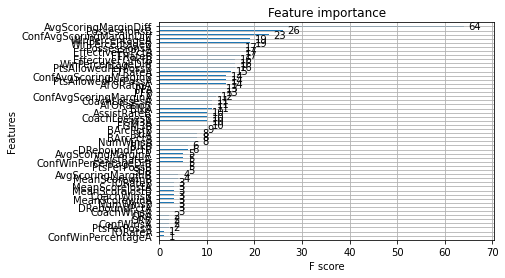

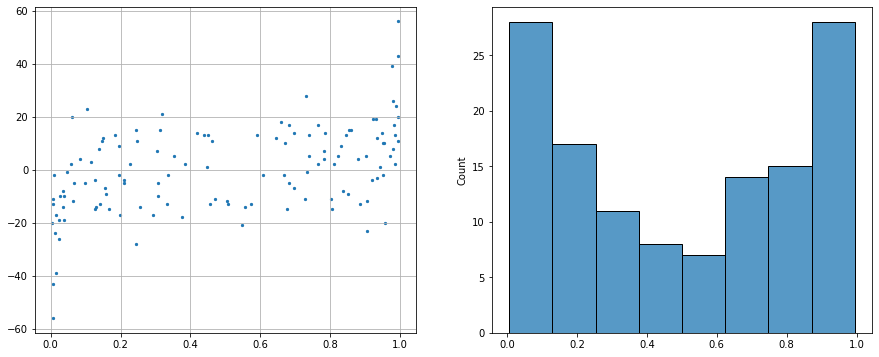

	 -> Scored 0.673
	 -> Correct Rate 0.641

Validating on season 2010


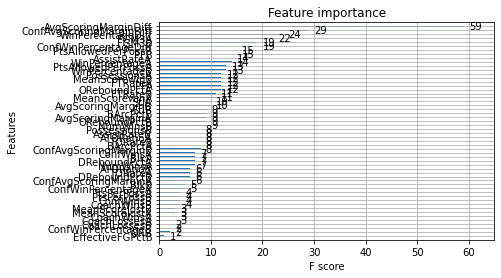

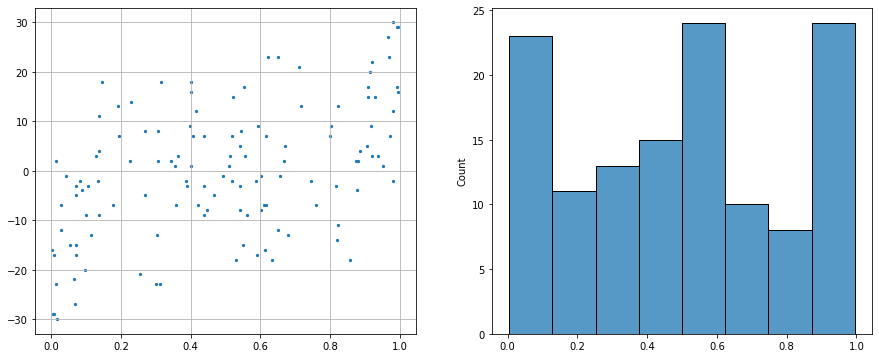

	 -> Scored 0.648
	 -> Correct Rate 0.625

Validating on season 2011


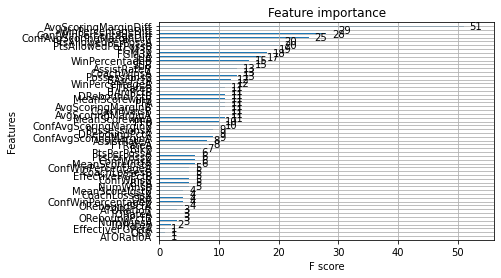

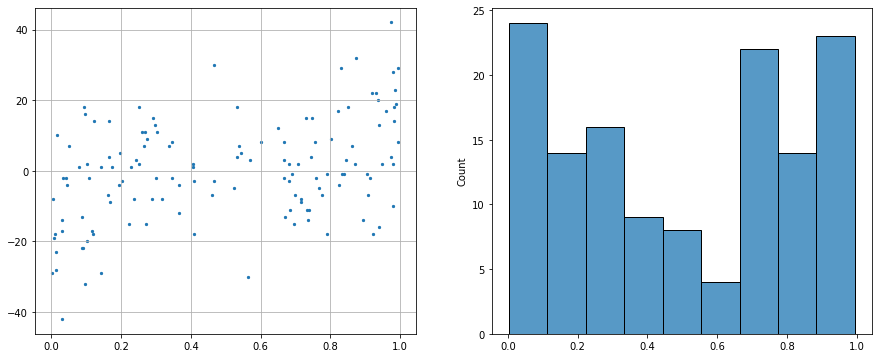

	 -> Scored 0.827
	 -> Correct Rate 0.575

Validating on season 2012


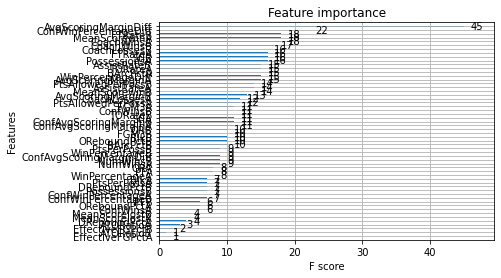

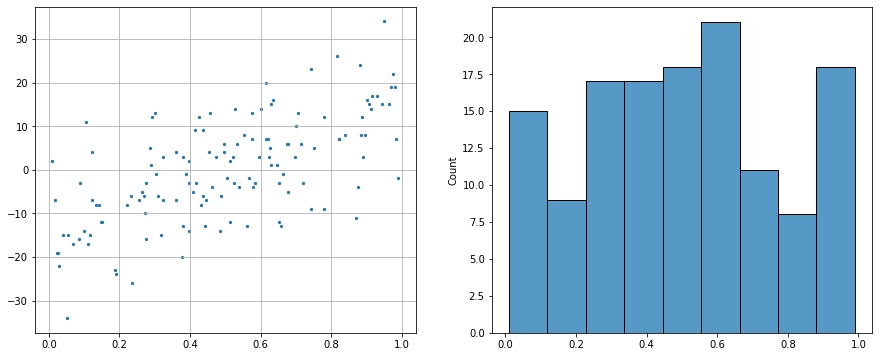

	 -> Scored 0.581
	 -> Correct Rate 0.716

Validating on season 2013


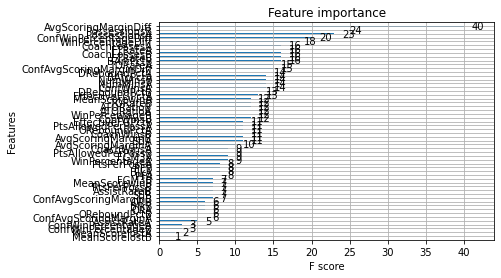

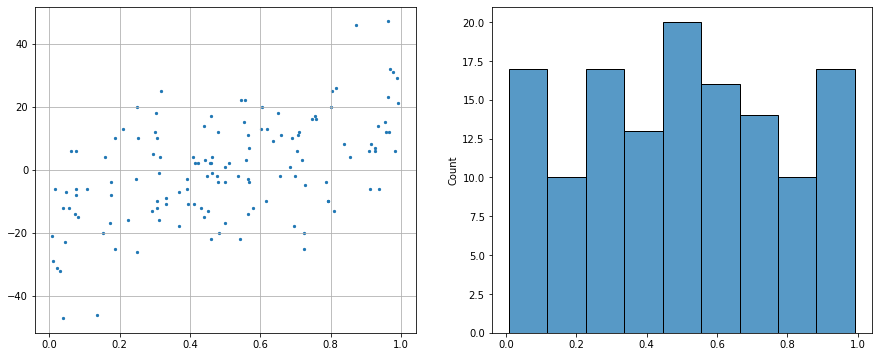

	 -> Scored 0.603
	 -> Correct Rate 0.679

Validating on season 2014


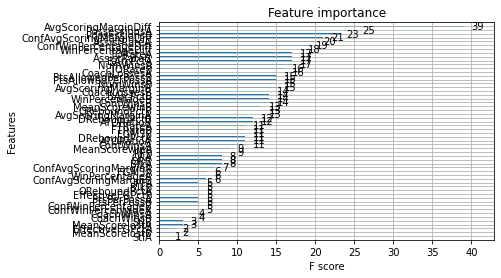

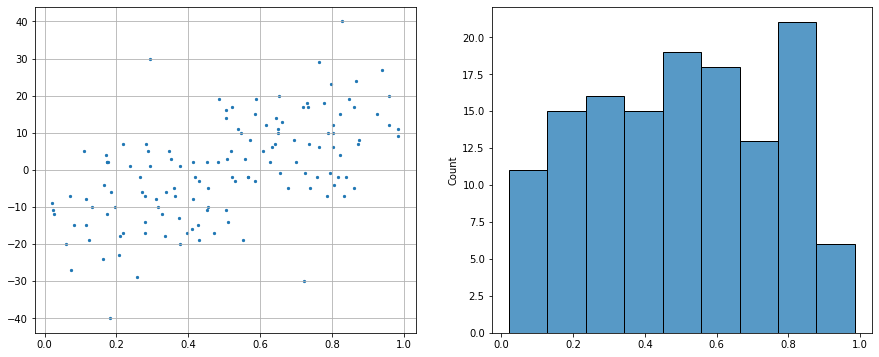

	 -> Scored 0.602
	 -> Correct Rate 0.709

Validating on season 2015


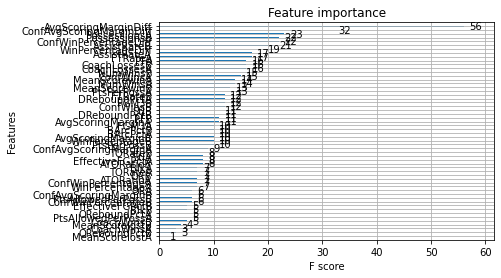

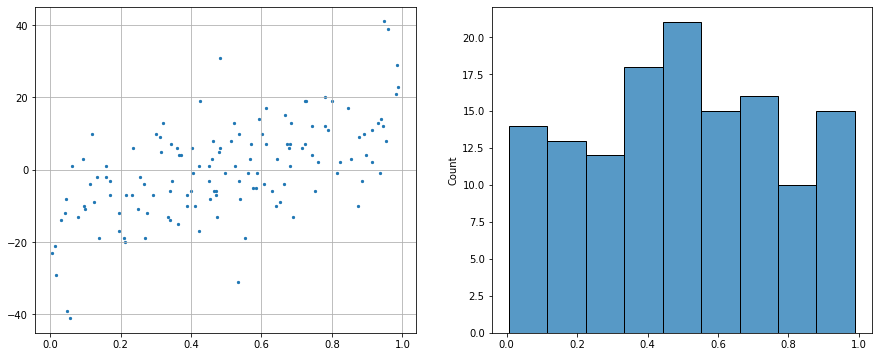

	 -> Scored 0.575
	 -> Correct Rate 0.694

Validating on season 2016


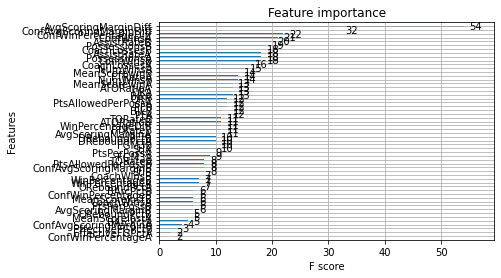

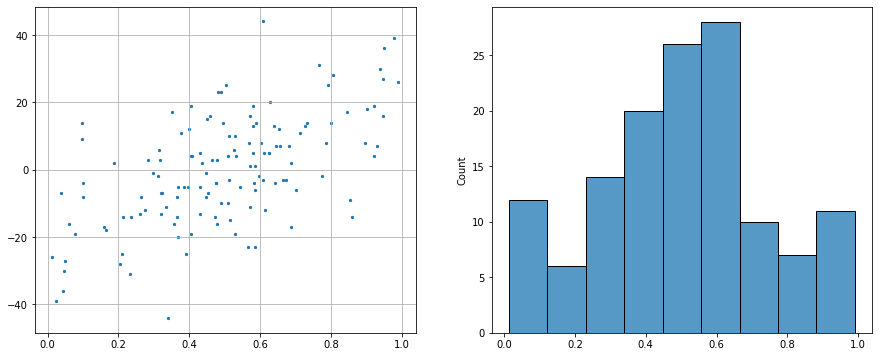

	 -> Scored 0.576
	 -> Correct Rate 0.687

Validating on season 2017


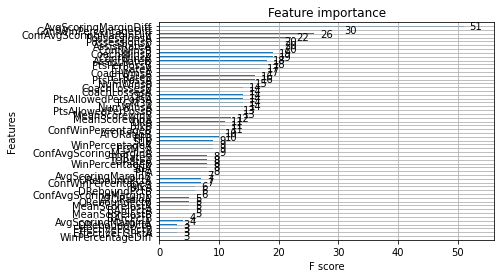

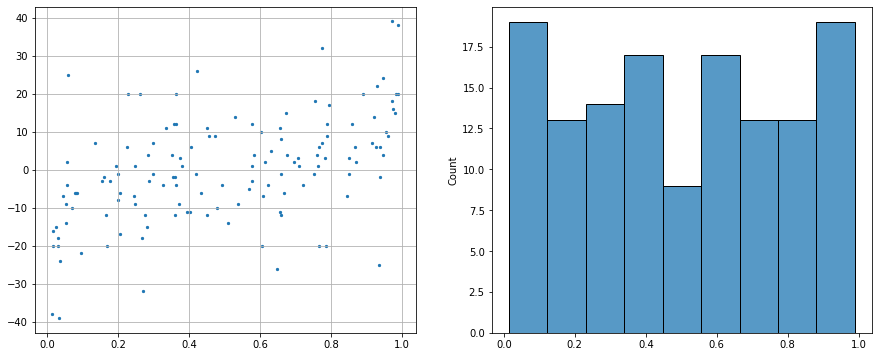

	 -> Scored 0.578
	 -> Correct Rate 0.687

Validating on season 2018


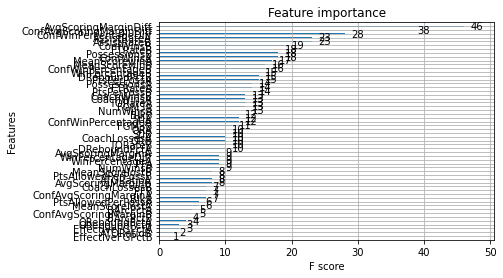

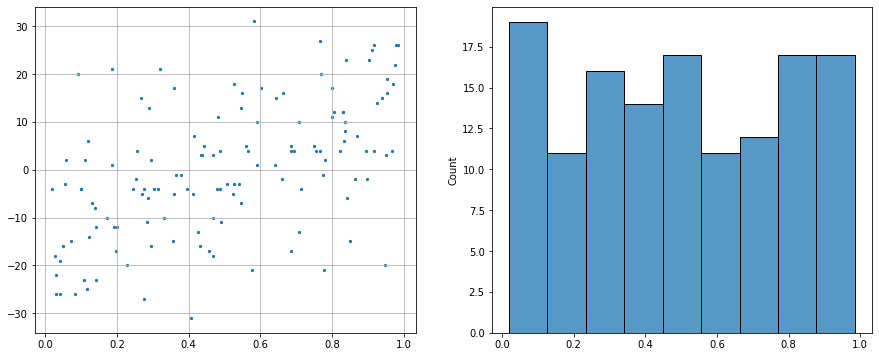

	 -> Scored 0.570
	 -> Correct Rate 0.731

Validating on season 2019


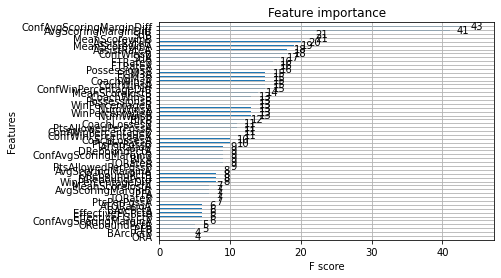

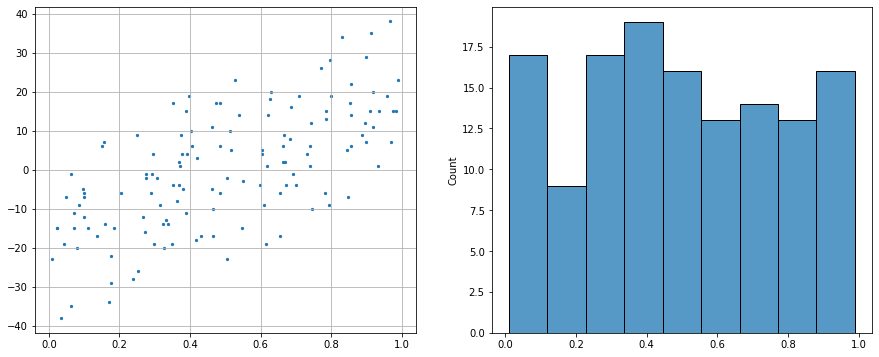

	 -> Scored 0.480
	 -> Correct Rate 0.739

Validating on season 2021


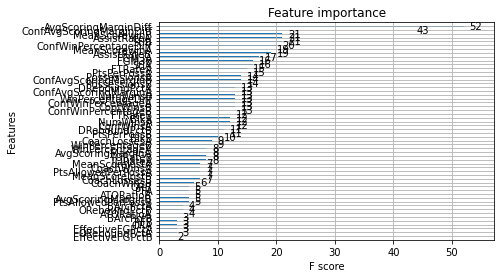

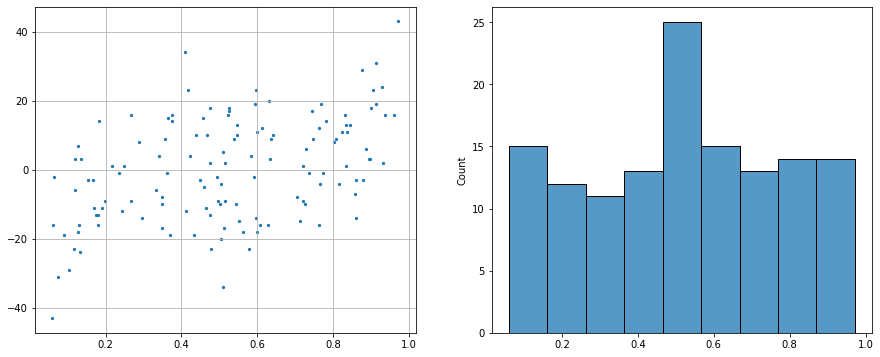

	 -> Scored 0.635
	 -> Correct Rate 0.629

 Local CV is 0.612

 Local Correct % is 0.676
All Important Vars: set()


In [ ]:
# TODO (2023) Make two different models for 1 and 2-seed matchups, then another
# for other matchups (or just model based on seed match-up)
# TODO (2023) Use prediction error and CIs to determine optimal type of model (LGBM, XGBoost, etc)
# TODO (collect histograms of percent probabilities that were incorrect)
# TODO (re-hyperparameter optimize)
def kfold_reg(df, df_test_=None, features=features_raw, plot=False, verbose=0, mode="reg"):
    seasons = sorted(df['Season'].unique())
    
    target = "ScoreDiff" if mode == "reg" else "WinA"
    seasons = seasons[4:len(seasons)]
    # min_samples_leafs = [18,19,20,21,22]
    # max_features_samples = [0.2,0.23,0.25,0.26,0.27]
    # min_sample_leaf_select = -1
    # max_features_samples_select = -1
    # min_log_loss = 1000
    importantVarLs = list()
    # for min_leaf in min_samples_leafs:
    #   for max_feat_sample in max_features_samples:
    cvs = []
    pred_tests = []
    rates = []
    difFromEven = []
    for season in seasons:
        if verbose:
            print(f'\nValidating on season {season}')
        df_train = df.loc[(df['Season'] < season)].copy()
        df_val = df[df['Season'] == season].copy()
        df_test = df_test_.copy()



        # modify to account for other variables (might need to change categorical vars to numerical)
        df_train, df_val, df_test = standard_scale(features, df_train, df_val, df_test)
            
        if mode == "reg":
                #model = ElasticNet(alpha=1, l1_ratio=0.5)
            model = RandomForestRegressor(n_estimators = 100, max_features = 0.33, 
                                      min_samples_leaf = 2,
                                      random_state = 42)
        else:
            model = xgb.XGBClassifier()
                
                
                #model = LGBMClassifier(**lgbm_params, boosting_type='gbdt', objective='binary', random_state=42)
                
                
        fittedModel = model.fit(df_train[features], df_train[target])
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
            
        if df_test is not None:
          if mode == "reg":
              pred_test = model.predict(df_test[features])
              pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
          else:
              pred_test = model.predict_proba(df_test[features])[:, 1]
                    
          pred_tests.append(pred_test)
                
        if plot:
            if (mode == "cls"):
              plot_importance(fittedModel)
            else:
              # list of x locations for plotting
              importantVars, unimportantVars = varianceImportance(model, features)
              print(f"Important Variables: {importantVars}")
              for importantVar in importantVars:
                importantVarLs.append(importantVar)
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
                # feature_importance = pd.Series(index = df_train.columns, data = np.abs(model.coef_))
                # n_selected_features = (feature_importance>0).sum()
                # print('{0:d} features, reduction of {1:2.2f}%'.format(
                # n_selected_features,(1-n_selected_features/len(feature_importance))*100))
                # feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

        loss = log_loss(df_val['WinA'].values, pred)
        predWins = np.where(pred>= 0.5)[0]
        actualWins = np.where(df_val['WinA'].values >= 0.5)[0]
        predLoss = np.where(pred< 0.5)[0]
        actualLoss = np.where(df_val['WinA'].values < 0.5)[0]
        matchingWins = np.intersect1d(predWins, actualWins)
        matchingLosses = np.intersect1d(predLoss, actualLoss)
          
        assert(len(predWins)+len(actualWins)+len(predLoss)+len(actualLoss) == 2*len(df_val['WinA'].values))
        rate = (len(matchingWins)+len(matchingLosses))/len(df_val['WinA'].values)
        cvs.append(loss)
        rates.append(rate)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
            print(f'\t -> Correct Rate {rate:.3f}')
    importantVarLs = set(importantVarLs)
                                
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    print(f'\n Local Correct % is {np.mean(rates):.3f}')
    print(f"All Important Vars: {importantVarLs}")
        # if (np.mean(cvs) < min_log_loss):
        #   print(f"Old Optimal Hyperparams: {max_features_samples_select}, {min_sample_leaf_select}")
        #   min_log_loss = np.mean(cvs)
        #   max_features_samples_select = max_feat_sample
        #   min_sample_leaf_select = min_leaf
        #   print(f"New Optimal Hyperparams: {max_features_samples_select}, {min_sample_leaf_select}")

    # print(f"Min Sample Leaf Optimal Param: {min_sample_leaf_select}")
    # print(f"Max Feature Sample Optimal Param: {max_features_samples_select}")


    
    return pred_tests, np.mean(rates)
# If using 538 predictions:
dfPred = df[df["Season"] >= 2016]
df_test_pred = df_test[df_test["Season"] >= 2016]


pred_tests, correct_rate = kfold_reg(df_fin, df_test_fin[features_no_overfit_guarantee], features_no_overfit_guarantee, plot=True, verbose=1, mode="cls")



In [ ]:
import random
random.seed(2022)
pred_test = np.mean(pred_tests, 0)
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = pred_test

sub2 = sub.copy()
choices = sub.loc[(sub['Pred'] <= 0.55) & (sub['Pred'] >= 0.45)]["Pred"] # increase margin for cls models
choicesRandom = random.choices(list(choices),k=int(((1-correct_rate)/(len(choices)/len(sub['Pred']))*len(list(choices)))))
indices = list(sub.loc[sub["Pred"].isin(choices)].reset_index()["index"])

sub2["1-Pred"] = 1 - sub2["Pred"]
sub2
sub2.loc[sub2["Pred"].isin(choices), "Pred"] = sub2.loc[sub2["Pred"].isin(choices), "1-Pred"]
sub2 = sub2.drop("1-Pred", axis = 1)


0.7171038824763903

In [ ]:
sub_tmp = df_test_fin[['ID', 'Pred']].copy()
sub_rf = sub_tmp.copy()
sub_lbgm = sub_tmp.copy()
sub_elastic_net = sub_tmp.copy()
sub_xgboost = sub_tmp.copy()
sub_mean = sub_tmp.copy()


sub_rf['Pred'] = pred_test_rf
sub_lbgm['Pred'] = pred_test_lbgm
sub_elastic_net['Pred'] = pred_test_elastic_net
sub_xgboost['Pred'] = pred_test_xgboost
sub_mean['Pred'] = pred_mean

sub_rf.to_csv('submission_rf.csv', index=False)
sub_lbgm.to_csv('submission_lbgm.csv', index=False)
sub_elastic_net.to_csv('submission_elastic_net.csv', index=False)
sub_xgboost.to_csv('submission_xgboost.csv', index=False)
sub_mean.to_csv('submission_mean.csv', index=False)


In [ ]:
sub.to_csv('submission_1_pt5.csv', index=False)
sub2.to_csv('submission_2_pt7.csv', index=False)

In [ ]:
teams = csvFiles["MTeams"].copy()


In [ ]:
teams.loc[teams["TeamID"]==1411]

,TeamID,TeamName,FirstD1Season,LastD1Season,HasTerminated
310,1411,TX Southern,1985,2022,0


In [ ]:
# Read Predictions
subVisualized = sub.copy()
subVisualized['Season'] = subVisualized['ID'].apply(lambda x: int(x.split('_')[0]))
subVisualized['TeamIDA'] = subVisualized['ID'].apply(lambda x: int(x.split('_')[1]))
subVisualized['TeamIDB'] = subVisualized['ID'].apply(lambda x: int(x.split('_')[2]))

In [ ]:

subVisualizedTmp = pd.merge(
    subVisualized,
    teams,
    how = "left",
    left_on = ["TeamIDA"],
    right_on = ["TeamID"]
).drop(["TeamIDA"],axis=1).rename(columns={'TeamName': 'TeamA'})
subVisualizedTmp = subVisualizedTmp.drop([ "TeamID", "FirstD1Season","LastD1Season","HasTerminated"],axis=1)

subVisualizedTmp = pd.merge(
    subVisualizedTmp,
    teams,
    how = "left",
    left_on = ["TeamIDB"],
    right_on = ["TeamID"]
).drop(["TeamIDB"],axis=1).rename(columns={'TeamName': 'TeamB'})
subVisualized = subVisualizedTmp.drop([ "TeamID", "FirstD1Season","LastD1Season","HasTerminated"],axis=1)

NameError: ignored

In [ ]:
subVisualized.to_csv('submissionVisual5.csv', index=False)

In [ ]:
def returnPred(df, TeamA_, TeamB_):
  dfTmp = df[df["TeamA"] == TeamA_]
  dfTmp2 = dfTmp[dfTmp["TeamB"] == TeamB_]

  return dfTmp2["Pred"]

returnPred(subVisualized, "Auburn","Houston")

276    0.718293
Name: Pred, dtype: float32

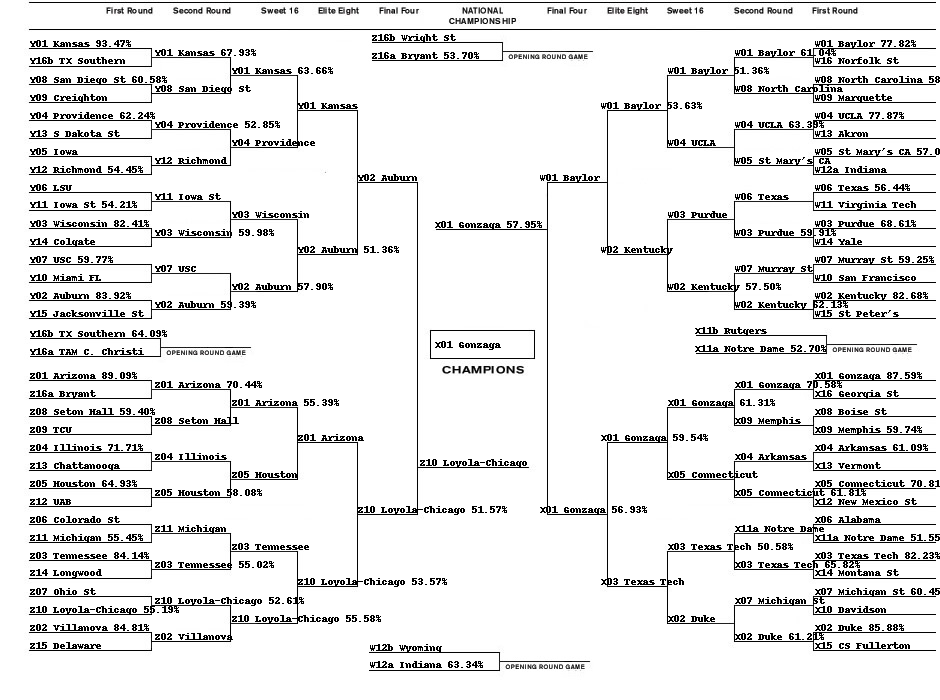

In [ ]:

try:
  from bracketeer import build_bracket
  from IPython.display import display, Image
except:
  !pip install binarytree==6.2.0
  !pip install bracketeer==0.2.0
  !pip install setuptools_scm==6.0.1
  from bracketeer import build_bracket
  from IPython.display import display, Image

inp = dataPath+ "/"

b = build_bracket(
outputPath='MNCAA2022.png',
teamsPath=inp+'MTeams.csv',
seedsPath=inp+'MNCAATourneySeeds.csv',
submissionPath='submission_2_pt7.csv',
slotsPath=inp+'MNCAATourneySlots.csv',
year=2022
)

display(Image(filename='./MNCAA2022.png'))

In [ ]:
subVisualized


,ID,Pred,Season,TeamA,TeamB
0,2022_1103_1104,0.113494,2022,Akron,Alabama
1,2022_1103_1112,0.058641,2022,Akron,Arizona
2,2022_1103_1116,0.110337,2022,Akron,Arkansas
3,2022_1103_1120,0.020891,2022,Akron,Auburn
4,2022_1103_1124,0.019116,2022,Akron,Baylor
...,...,...,...,...,...
2273,2022_1458_1461,0.849192,2022,Wisconsin,Wyoming
2274,2022_1458_1463,0.731982,2022,Wisconsin,Yale
2275,2022_1460_1461,0.569668,2022,Wright St,Wyoming
2276,2022_1460_1463,0.258503,2022,Wright St,Yale
